In [1]:
from datetime import datetime
from collections import Counter

import pandas as pd
import numpy as np
from numpy import log
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import optuna
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import xgboost as xgb
import lightgbm as lgb

import shap

/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Data Loading

In [2]:
df = pd.read_csv('./botswana_bank_customer_churn.csv', delimiter=',')

In [3]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'First Name', 'Date of Birth',
       'Gender', 'Marital Status', 'Number of Dependents', 'Occupation',
       'Income', 'Education Level', 'Address', 'Contact Information',
       'Customer Tenure', 'Customer Segment',
       'Preferred Communication Channel', 'Credit Score',
       'Credit History Length', 'Outstanding Loans', 'Churn Flag',
       'Churn Reason', 'Churn Date', 'Balance', 'NumOfProducts',
       'NumComplaints'],
      dtype='object')

In [4]:
df.shape

(115640, 25)

In [5]:
df.head(10)

,RowNumber,CustomerId,Surname,First Name,Date of Birth,Gender,Marital Status,Number of Dependents,Occupation,Income,...,Preferred Communication Channel,Credit Score,Credit History Length,Outstanding Loans,Churn Flag,Churn Reason,Churn Date,Balance,NumOfProducts,NumComplaints
0,1,83ef0b54-35f6-4f84-af58-5653ac0c0dc4,Smith,Troy,1987-08-29,Male,Divorced,3,Information systems manager,77710.14,...,Phone,397,24,41959.74,0,NaN,NaN,211359.05,1,0
1,2,009f115a-e5ca-4cf4-97d6-530140545e4e,Sullivan,Katrina,2000-02-07,Female,Married,1,Charity fundraiser,58209.87,...,Email,665,10,8916.67,0,NaN,NaN,30624.76,4,1
2,3,66309fd3-5009-44d3-a3f7-1657c869d573,Fuller,Henry,1954-02-03,Female,Single,1,Television production assistant,9794.01,...,Email,715,21,43270.54,0,NaN,NaN,111956.61,2,6
3,4,b02a30df-1a5f-4087-8075-2a35432da641,Young,Antonio,1991-01-15,Female,Divorced,5,Agricultural engineer,15088.98,...,Phone,747,17,17887.65,0,NaN,NaN,201187.61,1,0
4,5,0d932e5b-bb3a-4104-8c83-f84270f7f2ea,Andersen,John,1992-04-08,Female,Divorced,2,"Teacher, early years/pre",60726.56,...,Email,549,25,32686.84,0,NaN,NaN,60391.24,5,6
5,6,c18b027e-b108-4900-b413-dac87e2ee9b5,Gonzales,Ashley,1987-11-28,Male,Single,0,"Surveyor, building",55608.75,...,Email,809,27,37218.81,1,Account Closure,2024-07-31,31206.81,2,10
6,7,7091e271-7d2b-4e73-934f-8398e2a1dcbc,Wilcox,Daniel,1976-09-07,Female,Single,1,Publishing copy,22032.61,...,Email,690,29,26200.00,0,NaN,NaN,198443.50,2,1
7,8,d5e80b75-bd3f-4d8a-b847-0868f8eb9e40,Lopez,Johnny,1993-08-05,Male,Divorced,4,Industrial buyer,73462.72,...,Email,605,30,25156.25,0,NaN,NaN,96378.05,4,6
8,9,9eba62c1-0af0-4424-9218-435ece0689aa,Miles,Kelly,2001-08-03,Male,Divorced,3,Medical sales representative,30054.43,...,Phone,634,16,41854.08,0,NaN,NaN,108395.17,5,1
9,10,4eea7068-ea07-4898-bb04-6ccd8b729fc9,Thompson,Anthony,1991-01-12,Female,Divorced,5,Media buyer,24129.53,...,Phone,831,10,30914.02,0,NaN,NaN,99830.84,4,5


# EDA

## Desriptive Statistics

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115640 entries, 0 to 115639
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   RowNumber                        115640 non-null  int64  
 1   CustomerId                       115640 non-null  object 
 2   Surname                          115640 non-null  object 
 3   First Name                       115640 non-null  object 
 4   Date of Birth                    115640 non-null  object 
 5   Gender                           115640 non-null  object 
 6   Marital Status                   115640 non-null  object 
 7   Number of Dependents             115640 non-null  int64  
 8   Occupation                       115640 non-null  object 
 9   Income                           115640 non-null  float64
 10  Education Level                  115640 non-null  object 
 11  Address                          115640 non-null  object 
 12  Co

In [7]:
df.describe()

,RowNumber,Number of Dependents,Income,Customer Tenure,Credit Score,Credit History Length,Outstanding Loans,Churn Flag,Balance,NumOfProducts,NumComplaints
count,115640.000000,115640.000000,115640.000000,115640.000000,115640.000000,115640.000000,115640.000000,115640.000000,115640.000000,115640.000000,115640.000000
mean,57820.500000,2.502923,52641.363046,15.490591,574.299775,15.546602,25502.731792,0.121878,124639.209748,2.999274,4.991724
std,33382.536902,1.707249,27429.756390,8.654217,159.067499,8.654630,14127.859827,0.327147,72210.476638,1.411361,3.159283
min,1.000000,0.000000,5000.960000,1.000000,300.000000,1.000000,1000.430000,0.000000,1.060000,1.000000,0.000000
25%,28910.750000,1.000000,28857.070000,8.000000,436.000000,8.000000,13226.060000,0.000000,61991.915000,2.000000,2.000000
50%,57820.500000,3.000000,52658.110000,15.000000,574.000000,16.000000,25505.285000,0.000000,124505.890000,3.000000,5.000000
75%,86730.250000,4.000000,76364.157500,23.000000,712.000000,23.000000,37742.250000,0.000000,187122.922500,4.000000,8.000000
max,115640.000000,5.000000,99999.510000,30.000000,850.000000,30.000000,49999.690000,1.000000,249998.910000,5.000000,10.000000


# Creating Dataset to Analyze

In [8]:
df_to_analyze = df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'First Name', 'Contact Information', 'Date of Birth', 'Address'])
df_to_analyze['Churn Date'] = pd.to_datetime(df_to_analyze['Churn Date'])
df_to_analyze['Churn Flag'] = df_to_analyze['Churn Flag'].astype(object)
df_to_analyze

,Gender,Marital Status,Number of Dependents,Occupation,Income,Education Level,Customer Tenure,Customer Segment,Preferred Communication Channel,Credit Score,Credit History Length,Outstanding Loans,Churn Flag,Churn Reason,Churn Date,Balance,NumOfProducts,NumComplaints
0,Male,Divorced,3,Information systems manager,77710.14,High School,30,Retail,Phone,397,24,41959.74,0,NaN,NaT,211359.05,1,0
1,Female,Married,1,Charity fundraiser,58209.87,High School,27,SME,Email,665,10,8916.67,0,NaN,NaT,30624.76,4,1
2,Female,Single,1,Television production assistant,9794.01,High School,14,Retail,Email,715,21,43270.54,0,NaN,NaT,111956.61,2,6
3,Female,Divorced,5,Agricultural engineer,15088.98,High School,23,Corporate,Phone,747,17,17887.65,0,NaN,NaT,201187.61,1,0
4,Female,Divorced,2,"Teacher, early years/pre",60726.56,Master's,22,Corporate,Email,549,25,32686.84,0,NaN,NaT,60391.24,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115635,Male,Divorced,2,Chemical engineer,15704.15,Diploma,10,Corporate,Phone,350,23,26370.30,1,Account Closure,2024-06-24,20804.19,2,7
115636,Female,Single,3,Chartered legal executive (England and Wales),75792.62,High School,8,Corporate,Email,721,15,36229.64,0,NaN,NaT,10041.21,4,7
115637,Male,Married,4,Field trials officer,30142.28,Diploma,28,Retail,Email,773,19,6440.85,0,NaN,NaT,108833.43,1,4
115638,Female,Married,0,Legal secretary,58636.06,High School,22,Retail,Phone,584,23,5740.08,0,NaN,NaT,195548.32,5,6


In [9]:
df_to_analyze.columns

Index(['Gender', 'Marital Status', 'Number of Dependents', 'Occupation',
       'Income', 'Education Level', 'Customer Tenure', 'Customer Segment',
       'Preferred Communication Channel', 'Credit Score',
       'Credit History Length', 'Outstanding Loans', 'Churn Flag',
       'Churn Reason', 'Churn Date', 'Balance', 'NumOfProducts',
       'NumComplaints'],
      dtype='object')

In [10]:
df_to_analyze.shape

(115640, 18)

## Missing Value Analysis

In [11]:
nulls = round((df_to_analyze.isnull().sum() / len(df)) * 100, 2)
nulls

Gender                              0.00
Marital Status                      0.00
Number of Dependents                0.00
Occupation                          0.00
Income                              0.00
Education Level                     0.00
Customer Tenure                     0.00
Customer Segment                    0.00
Preferred Communication Channel     0.00
Credit Score                        0.00
Credit History Length               0.00
Outstanding Loans                   0.00
Churn Flag                          0.00
Churn Reason                       87.81
Churn Date                         87.81
Balance                             0.00
NumOfProducts                       0.00
NumComplaints                       0.00
dtype: float64

In [12]:
df_to_analyze["Churn Reason"].fillna("None", inplace = True)

/var/folders/dd/6c1yw5255dd59m89xkwwf4qr0000gn/T/ipykernel_44386/3035326899.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_to_analyze["Churn Reason"].fillna("None", inplace = True)


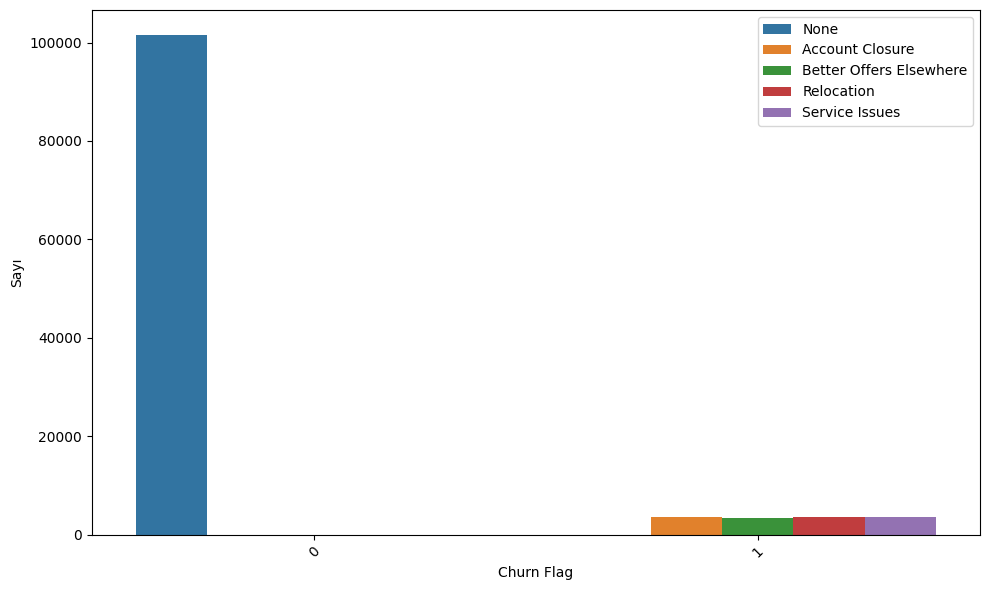

In [13]:
null_distribution = (
    df_to_analyze.groupby(["Churn Flag", "Churn Reason"]).size().reset_index(name="Count")
)
plt.figure(figsize=(10, 6))
sns.barplot(x="Churn Flag", y="Count", hue="Churn Reason", data=null_distribution)
plt.xlabel("Churn Flag")
plt.ylabel("Sayı")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Univariate Data Analysis

In [14]:
for i, col in enumerate(df_to_analyze.columns):
    if df_to_analyze[col].dtype == object:
        print(round((df_to_analyze[col].value_counts()/len(df_to_analyze))*100,2), "\n")

Gender
Female    50.01
Male      49.99
Name: count, dtype: float64 

Marital Status
Single      33.45
Divorced    33.33
Married     33.22
Name: count, dtype: float64 

Occupation
Engineer, materials                 0.19
Biochemist, clinical                0.19
Contractor                          0.19
Surveyor, commercial/residential    0.19
Surveyor, building                  0.19
                                    ... 
Engineering geologist               0.13
Civil engineer, consulting          0.13
Fitness centre manager              0.13
Designer, furniture                 0.13
Telecommunications researcher       0.12
Name: count, Length: 639, dtype: float64 

Education Level
Master's       25.05
Diploma        25.03
High School    24.96
Bachelor's     24.95
Name: count, dtype: float64 

Customer Segment
SME          33.64
Corporate    33.38
Retail       32.97
Name: count, dtype: float64 

Preferred Communication Channel
Email    50.19
Phone    49.81
Name: count, dtype: float64 

C

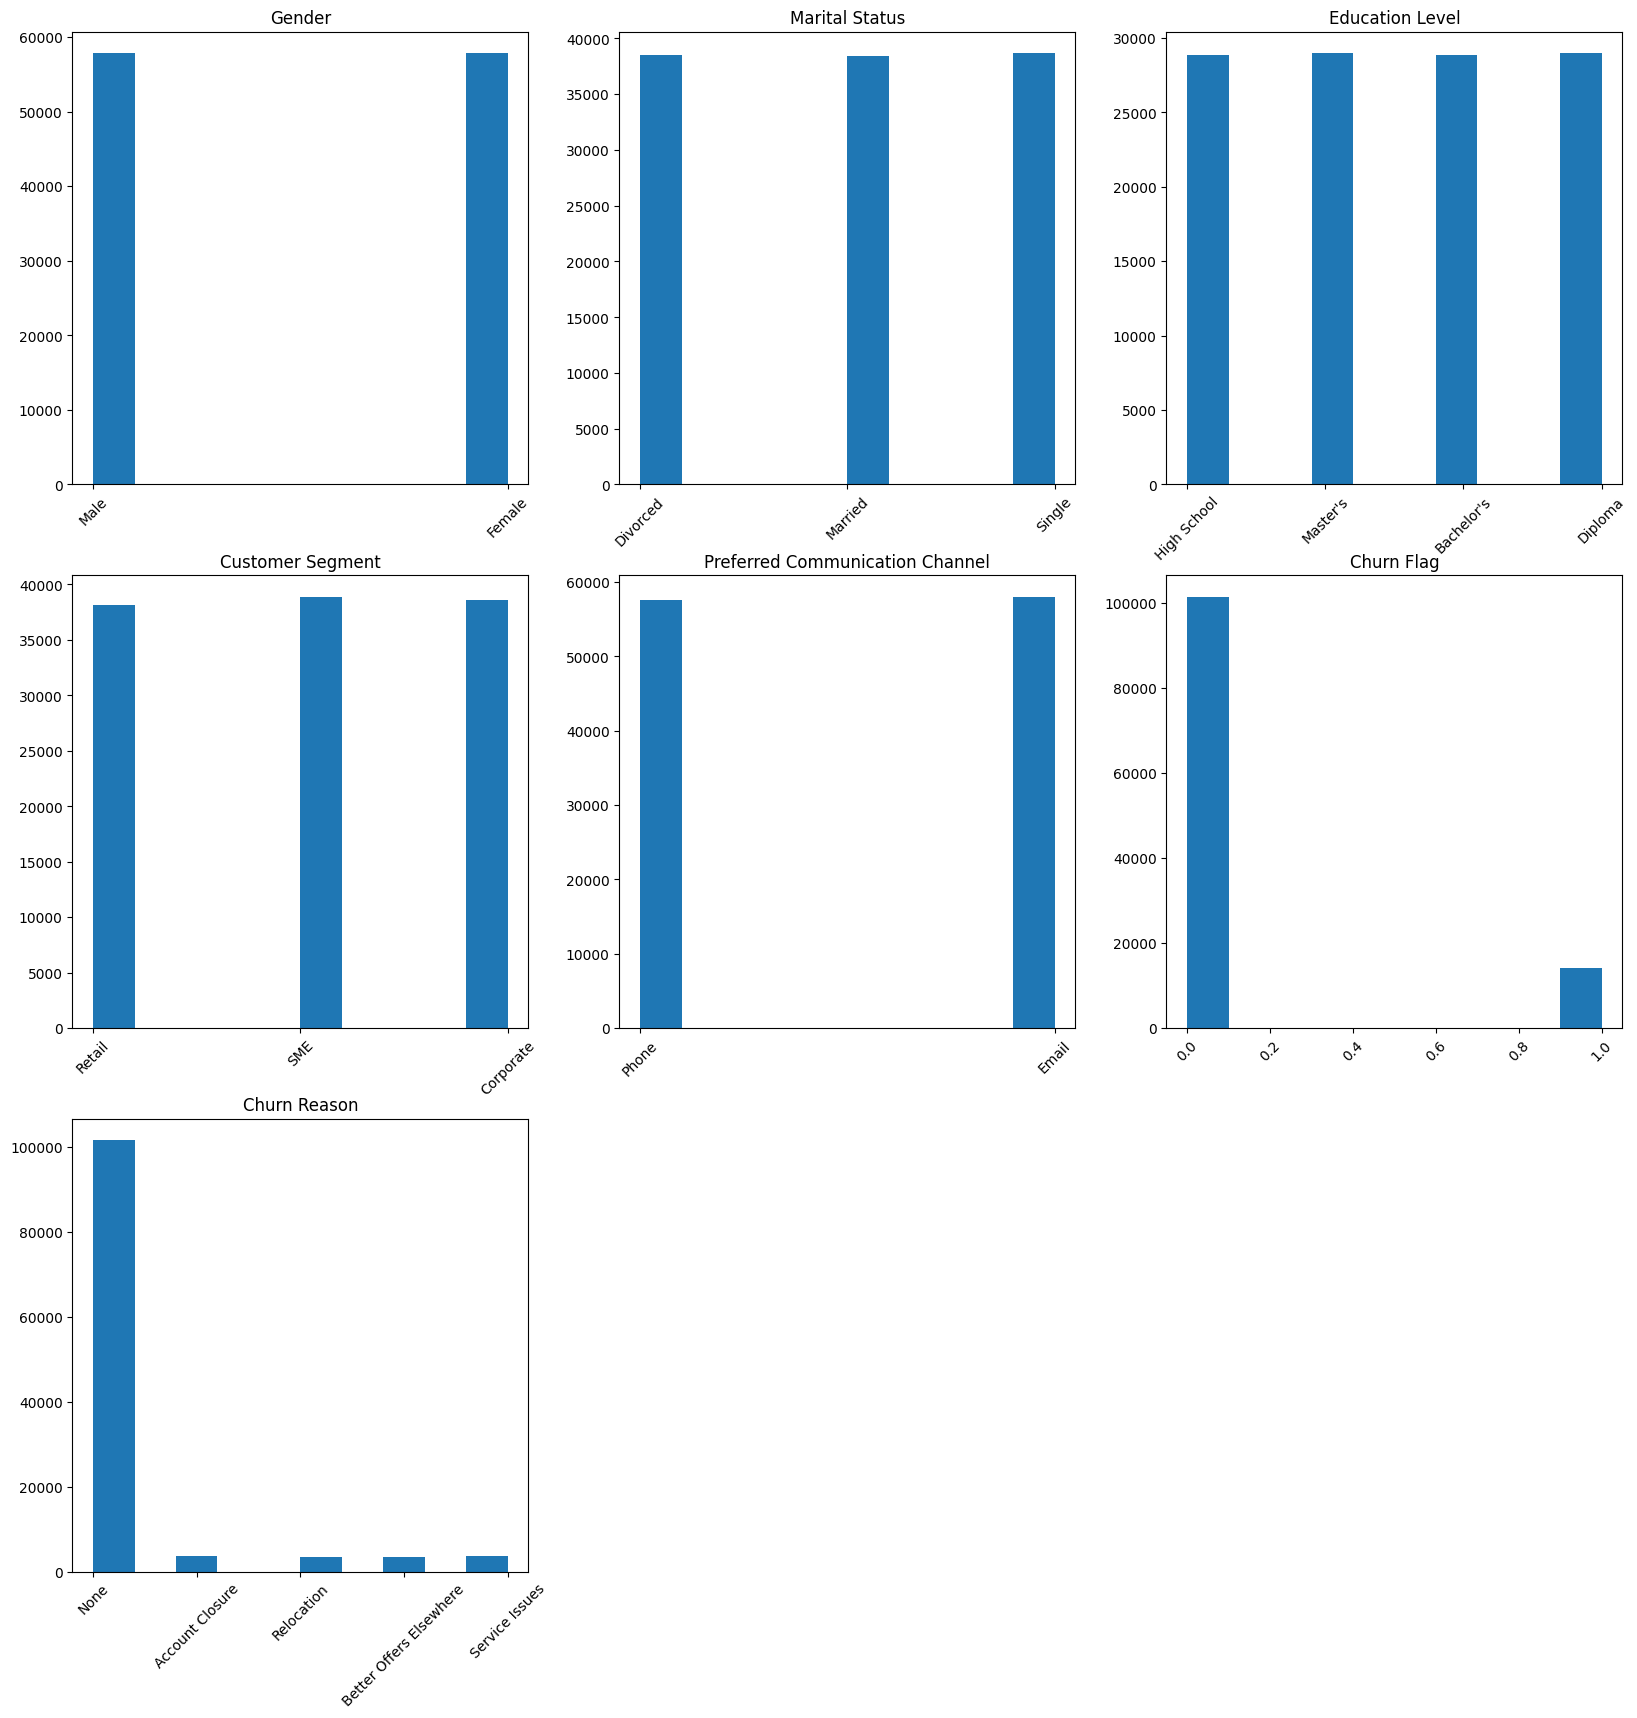

In [15]:
fig = plt.figure(figsize=(20, 20))

df_object = [col for col in df_to_analyze.columns if df_to_analyze[col].dtype == "object"]
df_object.remove('Occupation')
# print(df_object)
for i, col in enumerate(df_object):
    plt.subplot(3, 3, i + 1)
    plt.hist(df_to_analyze[col])
    plt.xticks(rotation=45)
    plt.title(col)

plt.show()

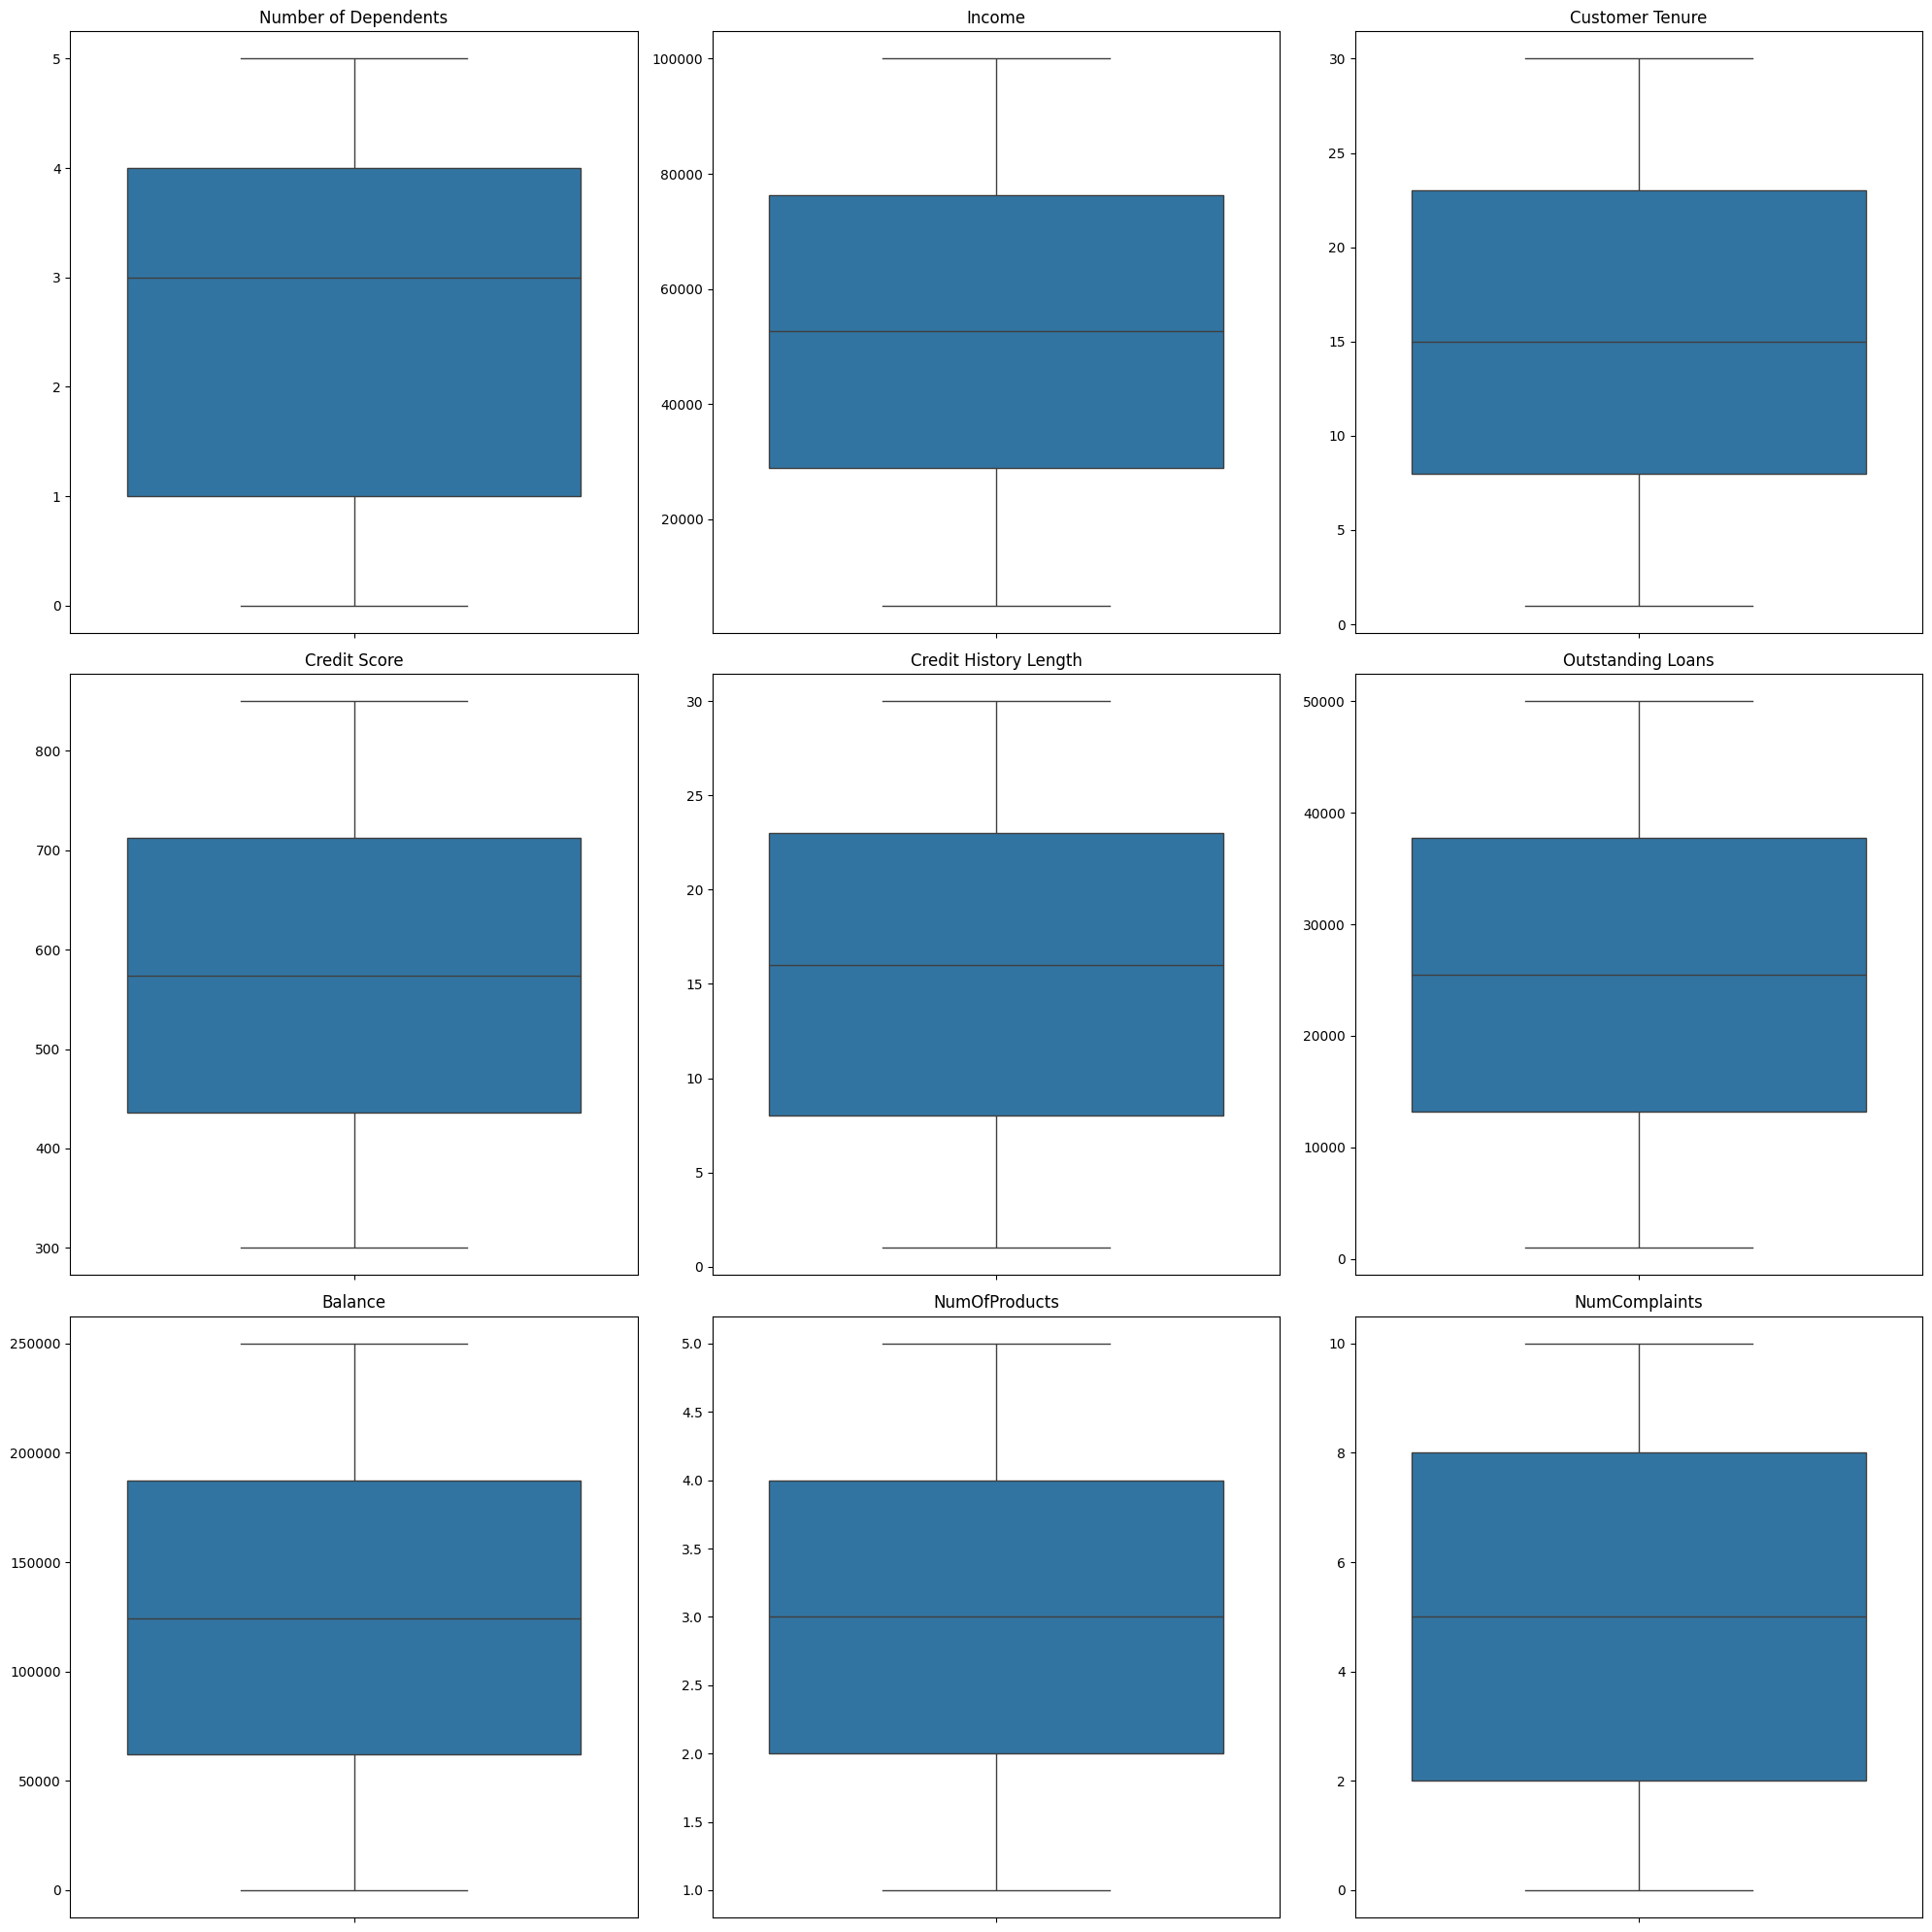

In [16]:
cont_list = [col for col in df_to_analyze.columns if (df_to_analyze[col].dtype == "float64") or (df_to_analyze[col].dtype == "int64")]
df_cont = df_to_analyze[cont_list]


fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten()  # Flatten for easy indexing

# Create boxplots
for i, col in enumerate(df_cont.columns):  # Limit to 36 columns
    sns.boxplot(data=df_cont[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Adjust layout
plt.tight_layout()
plt.show()

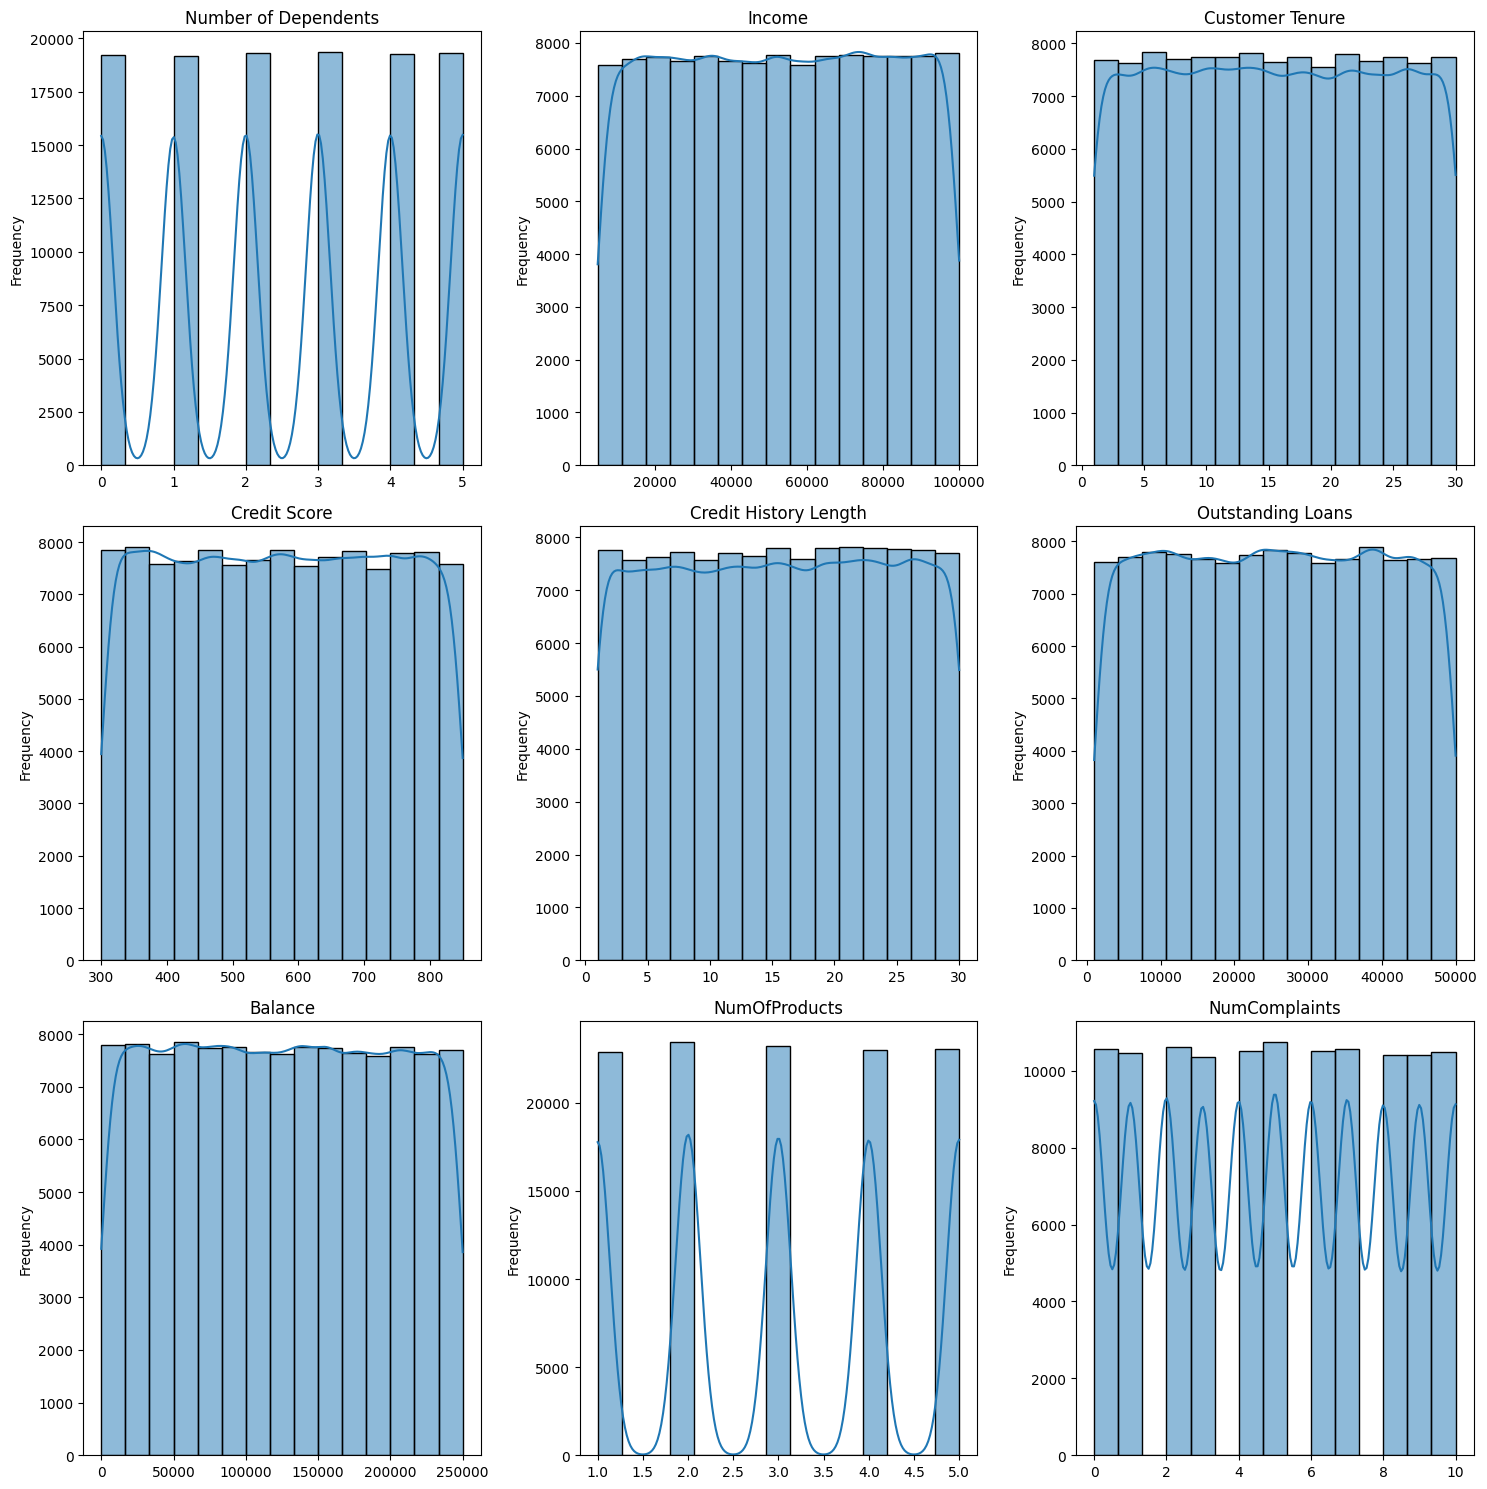

In [17]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()


for i, col in enumerate(df_cont.columns):
    sns.histplot(df_cont[col], kde=True, ax=axes[i], bins=15)
    axes[i].set_title(col)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()

## Multivariate Data Analysis

In [18]:
average_income_per_occupation = df_to_analyze.groupby('Occupation')['Income'].mean()
sorted_average_income = average_income_per_occupation.sort_values(ascending=False)

sorted_average_income

Occupation
Data processing manager               58291.873526
Personal assistant                    57991.269626
Public relations account executive    57947.819721
Child psychotherapist                 57746.703422
Therapist, sports                     57733.158000
                                          ...     
Scientist, water quality              47911.049333
Production engineer                   47707.642929
Designer, fashion/clothing            47599.123687
Designer, ceramics/pottery            47463.672865
Research scientist (life sciences)    46848.278806
Name: Income, Length: 639, dtype: float64

## Outlier Analysis

### IQR Method

In [19]:
Q1 = df_cont[df_cont.columns].quantile(0.25)
Q3 = df_cont[df_cont.columns].quantile(0.75)
IQR = Q3 - Q1
outliers = (df_cont[df_cont.columns] < (Q1 - 1.5 * IQR)) | (
    df_cont[df_cont.columns] > (Q3 + 1.5 * IQR)
)
print("IQR Aykırı Değerleri:")
print(outliers.sum())

IQR Aykırı Değerleri:
Number of Dependents     0
Income                   0
Customer Tenure          0
Credit Score             0
Credit History Length    0
Outstanding Loans        0
Balance                  0
NumOfProducts            0
NumComplaints            0
dtype: int64


In [20]:
z_scores = np.abs(stats.zscore(df_cont[df_cont.columns]))
# Find indices of outliers based on z-scores
outliers = np.where(z_scores > 3)[0]  # You can adjust the threshold
print("Z-Skor Aykırı Değerleri:")
len(outliers)

Z-Skor Aykırı Değerleri:


0

## Correlation Analysis

<Figure size 2000x2000 with 0 Axes>

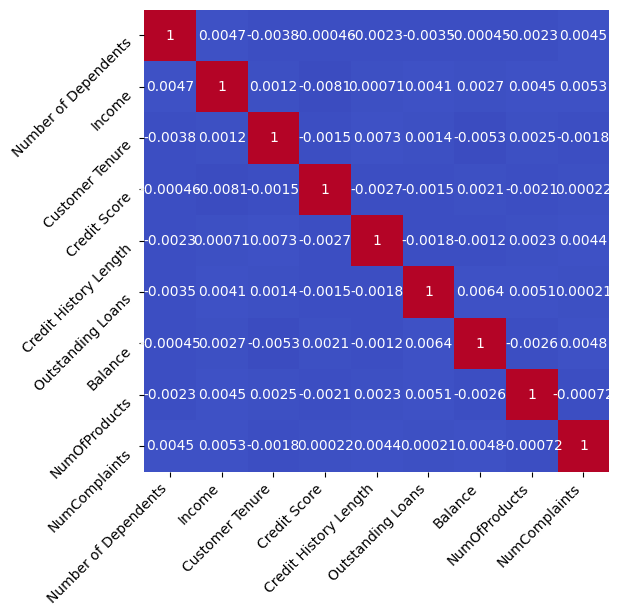

In [21]:
fig = plt.figure(figsize=(20, 20))

correlation = df_to_analyze[df_cont.columns].corr()

plt.figure(figsize=(6, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", cbar=False)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45, va="top")

plt.show()

## Target Based Analysis

In [22]:
def shannon_entropy(seq):
    n = len(seq)
    classes = [(clas, float(count)) for clas, count in Counter(seq).items()]
    k = len(classes)

    H = -sum(
        [(count / n) * log((count / n)) for clas, count in classes]
    )  # shannon entropy
    return H / log(k)


entropy = shannon_entropy(df_to_analyze["Churn Flag"])
print(entropy)

0.5347358258282555


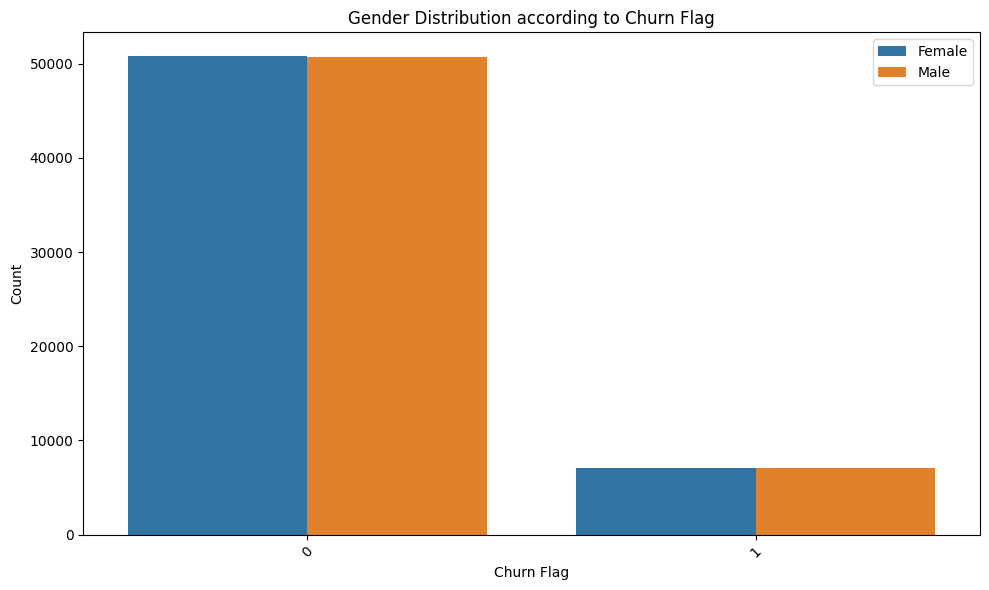

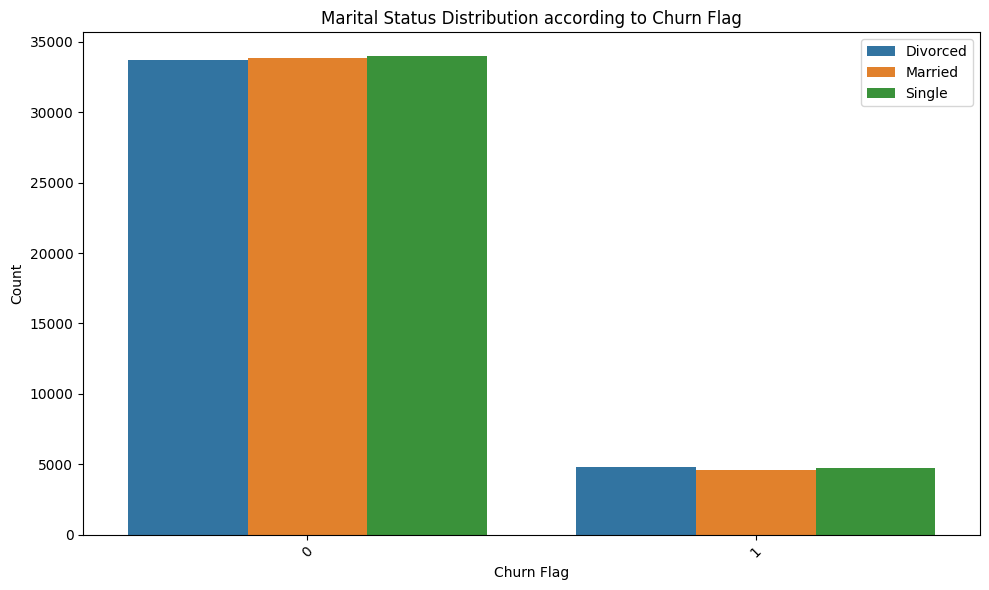

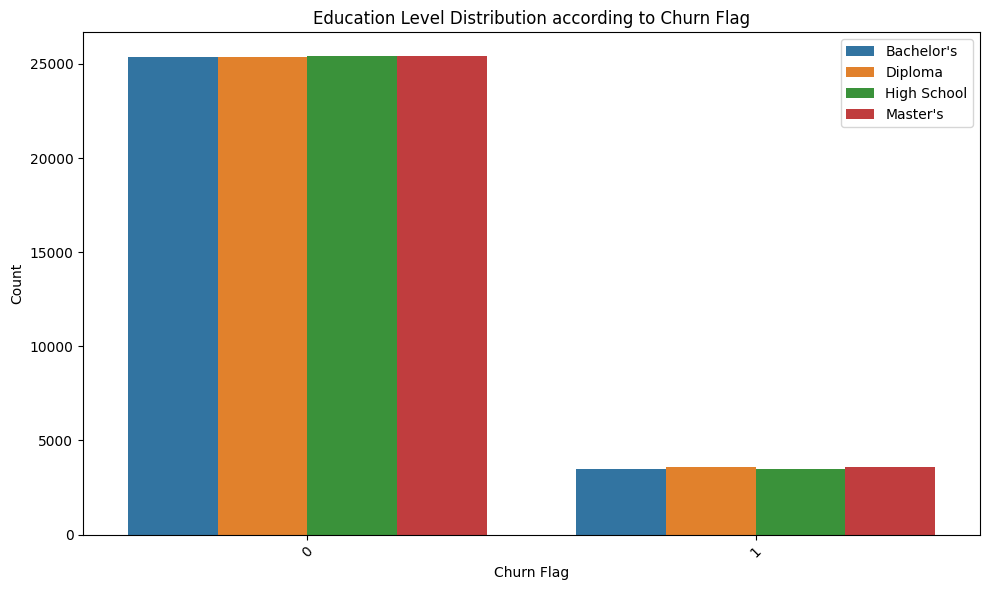

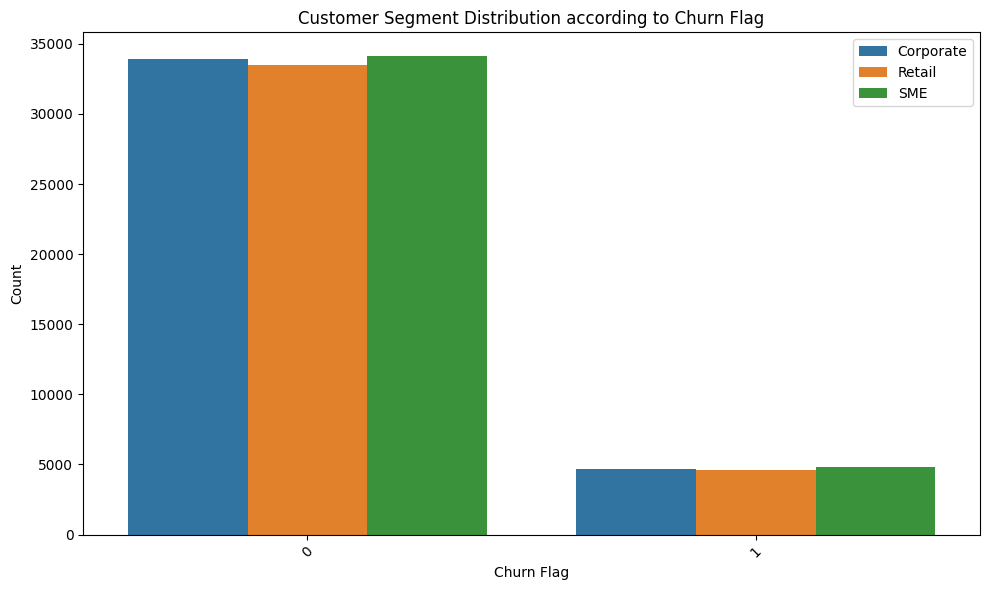

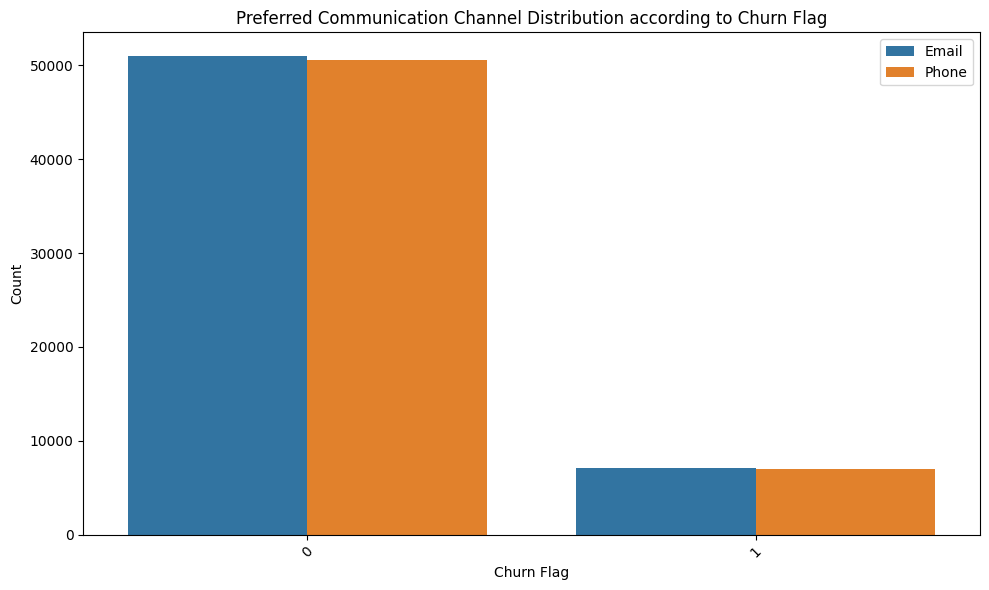

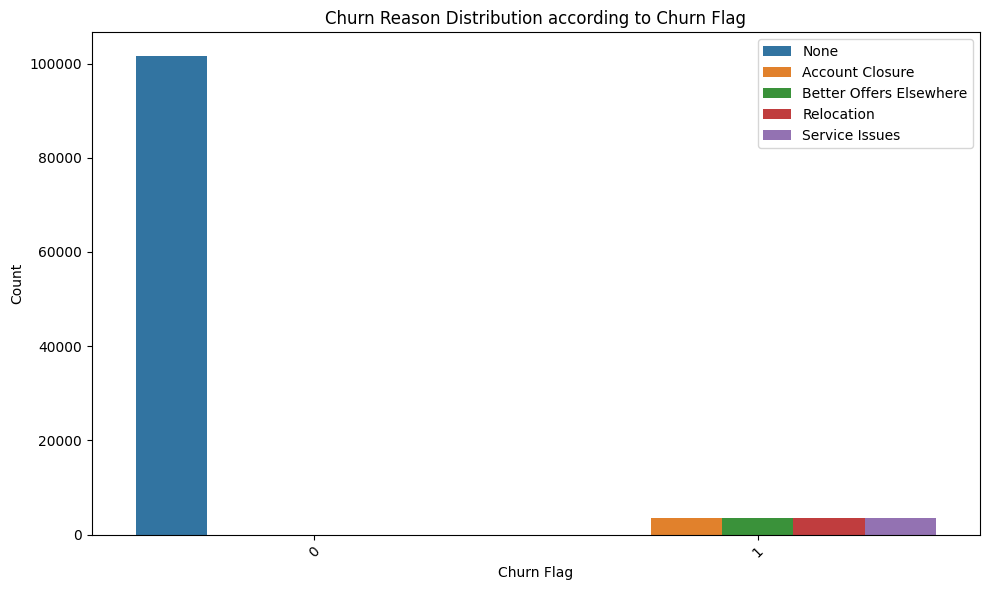

In [23]:
for i in df_object:   
    if i == 'Churn Flag':
        continue
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Churn Flag", y="Count", hue=i, data=(
        df_to_analyze.groupby(["Churn Flag", i]).size().reset_index(name="Count")
    ))
    plt.xlabel("Churn Flag")
    plt.ylabel("Count")
    plt.title(f"{i} Distribution according to Churn Flag")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Data Manipulation & Feature Engineering

In [24]:
df_enriched = df_to_analyze.copy()

df_enriched['Age'] = (datetime.now() - pd.to_datetime(df['Date of Birth'])) / pd.Timedelta(days=365.25)
df_enriched['Age'] = df_enriched['Age'].astype(int)

#behavioral
df_enriched['complaint_per_product'] = df_to_analyze['NumComplaints'] / df_to_analyze['NumOfProducts']
df_enriched['complaint_frequency'] = df_to_analyze['NumComplaints'] / df_to_analyze['Customer Tenure']
df_enriched['credit_utilization_length'] = df_to_analyze['Credit History Length'] / df_to_analyze['Customer Tenure']

#economical-financial
df_enriched['product_utils'] = df_to_analyze['NumOfProducts'] / df_to_analyze['Balance']
df_enriched['product_purchase_freq'] = df_to_analyze['NumOfProducts'] / df_to_analyze['Customer Tenure']
df_enriched['product_purchase_to_income'] = df_to_analyze['NumOfProducts'] / df_to_analyze['Income']

df_enriched['debt_to_income'] = df_to_analyze['Outstanding Loans'] / df_to_analyze['Income']
df_enriched['loan_utils'] = df_to_analyze['Outstanding Loans'] / df_to_analyze['Balance']

df_enriched['balance_to_income'] = df_to_analyze['Balance'] / df_to_analyze['Income']


#demographic-economical
df_enriched['income_per_dependent'] = df_to_analyze['Income'] / (df_to_analyze['Number of Dependents'] + 0.1)


#binning
def credit_score_categorization(credit_score):
    if 300 <= credit_score <= 579:
        return 1
    elif 580 <= credit_score <= 669:
        return 2
    elif 670 <= credit_score <= 739:
        return 3
    elif 740 <= credit_score <= 799:
        return 4
    elif 800 <= credit_score <= 850:
        return 5
    else:
        return 0

# Example usage
df_enriched['Credit Score'] = df_to_analyze['Credit Score'].apply(credit_score_categorization)






In [25]:
df_enriched.shape

(115640, 29)

In [26]:
df_enriched.columns

Index(['Gender', 'Marital Status', 'Number of Dependents', 'Occupation',
       'Income', 'Education Level', 'Customer Tenure', 'Customer Segment',
       'Preferred Communication Channel', 'Credit Score',
       'Credit History Length', 'Outstanding Loans', 'Churn Flag',
       'Churn Reason', 'Churn Date', 'Balance', 'NumOfProducts',
       'NumComplaints', 'Age', 'complaint_per_product', 'complaint_frequency',
       'credit_utilization_length', 'product_utils', 'product_purchase_freq',
       'product_purchase_to_income', 'debt_to_income', 'loan_utils',
       'balance_to_income', 'income_per_dependent'],
      dtype='object')

# ML Model Building

## Data Encoding

In [27]:
config = {
    'target_column': ['Churn Flag'],
    'sampling_rate': 0.04, # Majority class
    'top_n_percentages': [0.01, 0.02, 0.03, 0.04, 0.05],
    'categorical_features': ['Gender', 'Marital Status', 'Occupation', 'Education Level', 'Customer Segment', 'Preferred Communication Channel', 'Credit Score'],
    'nominal_features': ['Gender', 'Marital Status', 'Occupation', 'Preferred Communication Channel'],
    'ordinal_feaures': ['Education Level', 'Customer Segment', 'Credit Score'],
    'ignore_features': ['Churn Reason', 'Churn Date'],
    'lgbm_params': {
        'boosting': 'gbdt', #gbdt, dart
        'objective': 'binary',
        'n_jobs': 15
    },    
}

## Model Training

In [28]:
def train_model(X, y, params, categorical_features):
    model = lgb.LGBMClassifier(**params)
    model.fit(X, y, categorical_feature=categorical_features)
    return model

def evaluate_model(model, X, y):
    preds = model.predict(X)
    preds_proba = model.predict_proba(X)
    
    metrics = {
        'accuracy': accuracy_score(y, preds),
        'f1': f1_score(y, preds),
        'precision': precision_score(y, preds),
        'recall': recall_score(y, preds),
        'confusion_matrix': confusion_matrix(y, preds),
        'roc_auc': roc_auc_score(y, preds)
    }
    
    return metrics, preds_proba

In [29]:
def get_default_params():
    return {k: v['default'] for k, v in lightgbm_hyperparameters.items()}

In [30]:
lightgbm_hyperparameters = {
    # Maximum number of leaves in one tree. Main parameter to control model complexity. 
    # Larger value can improve accuracy but may lead to overfitting.
    'num_leaves': {
        'default': 20,
        'range': (10, 100),
        'type': int
    },
    
    # Boosting learning rate. Lower values are generally better but require more iterations.
    'learning_rate': {
        'default': 0.05,
        'range': (0.01, 0.1),
        'type': float
    },
    
    # Number of boosting iterations. More can improve accuracy but may lead to overfitting.
    'n_estimators': {
        'default': 200,
        'range': (100, 500),
        'type': int
    },
    
    # Maximum tree depth. -1 means no limit. Controls model complexity.
    'max_depth': {
        'default': 5,
        'range': (3, 15),
        'type': int
    },
    
    # Minimum number of data needed in a child(leaf). Larger values prevent overfitting.
    'min_child_samples': {
        'default': 20,
        'range': (10, 50),
        'type': int
    },
    
    # Fraction of data to randomly sample for each tree. Values < 1.0 can help prevent overfitting.
    'subsample': {
        'default': 0.5,
        'range': (0.5, 0.7),
        'type': float
    },
    
    # Fraction of features to randomly select for each tree. Values < 1.0 can help prevent overfitting.
    'colsample_bytree': {
        'default': 0.5,
        'range': (0.5, 0.7),
        'type': float
    },
    
    # L1 regularization term. Larger values increase regularization.
    'reg_alpha': {
        'default': 0.2,
        'range': (0.1, 0.5),
        'type': float
    },
    
    # L2 regularization term. Larger values increase regularization.
    'reg_lambda': {
        'default': 0.2,
        'range': (0.1, 0.5),
        'type': float
    },
    
    # Minimum loss reduction required to make a split. Larger values prevent overfitting.
    'min_split_gain': {
        'default': 0.2,
        'range': (0.1, 0.5),
        'type': float
    },
    
    # Max number of bins for feature values. Smaller number may reduce overfitting.
    'max_bin': {
        'default': 20,
        'range': (10, 100),
        'type': int
    },
    
    # Frequency for bagging. 0 means disable bagging. Non-zero enables bagging.
    'bagging_freq': {
        'default': 3,
        'range': (3, 5),
        'type': int
    },
    
    # Minimum sum of instance weight (hessian) needed in a child. Larger values prevent overfitting.
    'min_child_weight': {
        'default': 0.05,
        'range': (0.01, 0.1),
        'type': float
    },
    
    # Smoothing term used for categorical features. Larger values reduce noise in categorical features.
    'cat_smooth': {
        'default': 30,
        'range': (1, 100),
        'type': float
    },
    
    # L2 regularization in categorical split. Larger values increase regularization for categorical features.
    'cat_l2': {
        'default': 0.1,
        'range': (0.1, 1),
        'type': float
    },
    
    # Maximum number of categories to group for each categorical feature. Can help reduce overfitting.
    'max_cat_threshold': {
        'default': 10,
        'range': (8, 32),
        'type': int
    },
    
    # Number of samples for constructing bins. Larger values may increase accuracy but also training time.
    'subsample_for_bin': {
        'default': 500,
        'range': (100, 1000),
        'type': int
    },
    
    # Minimum number of data per categorical group. Helps ensure reliable splits for categorical features.
    'min_data_per_group': {
        'default': 5,
        'range': (1, 10),
        'type': int
    }
}

In [31]:
df_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115640 entries, 0 to 115639
Data columns (total 29 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   Gender                           115640 non-null  object        
 1   Marital Status                   115640 non-null  object        
 2   Number of Dependents             115640 non-null  int64         
 3   Occupation                       115640 non-null  object        
 4   Income                           115640 non-null  float64       
 5   Education Level                  115640 non-null  object        
 6   Customer Tenure                  115640 non-null  int64         
 7   Customer Segment                 115640 non-null  object        
 8   Preferred Communication Channel  115640 non-null  object        
 9   Credit Score                     115640 non-null  int64         
 10  Credit History Length            115640 non-

In [32]:
for col in config['categorical_features']:
    df_enriched[col] = df_enriched[col].astype('category')

In [33]:
X = df_enriched.drop(columns=config['target_column'] + config['ignore_features'])  # Features
y = df_enriched[config['target_column']]                # Target
y = y.astype(int)
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42  # 20% for testing, fixed random state for reproducibility
)

In [34]:
config['nominal_features']

['Gender', 'Marital Status', 'Occupation', 'Preferred Communication Channel']

In [35]:
model = train_model(X_train, y_train, 
                    config['lgbm_params'] | get_default_params(), 
                    config['categorical_features'])

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Number of positive: 11267, number of negative: 81245
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhea

/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


# ML Model Evaluation

In [36]:
metrics, preds_proba = evaluate_model(model, X_test, y_test)

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


In [37]:
preds_proba

array([[9.91416000e-01, 8.58399958e-03],
       [8.64416285e-01, 1.35583715e-01],
       [9.99953403e-01, 4.65974160e-05],
       ...,
       [8.57240268e-01, 1.42759732e-01],
       [9.99654487e-01, 3.45512613e-04],
       [9.99816147e-01, 1.83852672e-04]])

In [38]:
metrics

{'accuracy': 0.9797215496368039,
 'f1': 0.9159648808457267,
 'precision': 0.9281045751633987,
 'recall': 0.9041386628935267,
 'confusion_matrix': array([[20103,   198],
        [  271,  2556]]),
 'roc_auc': 0.947192724383072}

In [39]:
df_test = pd.concat([X_test, y_test], axis=1)

In [40]:
df_test['label_0_prob'], df_test['label_1_prob'] = preds_proba[:, 0], preds_proba[:, 1]

In [41]:
def get_top_N_metrics(df, N, target_col):
    topN = df.sort_values(['label_1_prob'], ascending=False).head(int(df.shape[0] * N))
    topN_churners = topN[target_col].sum()
    all_churners = df[target_col].sum()
    all_churn_rate = all_churners / df.shape[0]
    topN_precision = topN_churners / topN.shape[0]
    topN_recall = topN_churners / all_churners
    topN_lift = topN_precision / all_churn_rate
    
    return pd.DataFrame({
        "Percentage (%)": [N*100],
        "TopN #Cust": [topN.shape[0]],
        "TopN #churners": [topN_churners],
        "#allchurners": [all_churners],
        "All Churn Rate (%)": [all_churn_rate*100],
        "TopN Precision (%)": [topN_precision*100],
        "TopN Recall (%)": [topN_recall*100],
        "TopN Lift": [topN_lift]
    })

def find_optimal_threshold_for_precision(y_true, y_pred_proba, target_precision=None, 
                                         precision_range=(0.2, 1.0), step=0.025):
    thresholds = np.arange(precision_range[0], precision_range[1], step)
    best_threshold = 0.5
    best_metrics = metrics
    
    for threshold in thresholds:
        if target_precision is not None:
            if metrics['precision'] >= target_precision and metrics['recall'] > best_metrics['recall']:
                best_threshold = threshold
                best_metrics = metrics
        else:
            if metrics['precision'] > best_metrics['precision']:
                best_threshold = threshold
                best_metrics = metrics
    
    return best_threshold, best_metrics

In [42]:
results = []
for i in [0.01, 0.05, 0.1, 0.20, 0.3, 0.4, 0.5]:
    top_n_metrics = get_top_N_metrics(df_test, N=i, target_col=config['target_column'])
    results.append(top_n_metrics)
    
top_n_results = pd.concat(results, ignore_index=True)

In [43]:
top_n_results

,Percentage (%),TopN #Cust,TopN #churners,#allchurners,All Churn Rate (%),TopN Precision (%),TopN Recall (%),TopN Lift
0,1.0,231,Churn Flag 231 dtype: int64,Churn Flag 2827 dtype: int64,Churn Flag 12.223279 dtype: float64,Churn Flag 100.0 dtype: float64,Churn Flag 8.171206 dtype: float64,Churn Flag 8.181111 dtype: float64
1,5.0,1156,Churn Flag 1156 dtype: int64,Churn Flag 2827 dtype: int64,Churn Flag 12.223279 dtype: float64,Churn Flag 100.0 dtype: float64,Churn Flag 40.891404 dtype: float64,Churn Flag 8.181111 dtype: float64
2,10.0,2312,Churn Flag 2274 dtype: int64,Churn Flag 2827 dtype: int64,Churn Flag 12.223279 dtype: float64,Churn Flag 98.356401 dtype: float64,Churn Flag 80.438628 dtype: float64,Churn Flag 8.046646 dtype: float64
3,20.0,4625,Churn Flag 2827 dtype: int64,Churn Flag 2827 dtype: int64,Churn Flag 12.223279 dtype: float64,Churn Flag 61.124324 dtype: float64,Churn Flag 100.0 dtype: float64,Churn Flag 5.000649 dtype: float64
4,30.0,6938,Churn Flag 2827 dtype: int64,Churn Flag 2827 dtype: int64,Churn Flag 12.223279 dtype: float64,Churn Flag 40.746613 dtype: float64,Churn Flag 100.0 dtype: float64,Churn Flag 3.333526 dtype: float64
5,40.0,9251,Churn Flag 2827 dtype: int64,Churn Flag 2827 dtype: int64,Churn Flag 12.223279 dtype: float64,Churn Flag 30.558859 dtype: float64,Churn Flag 100.0 dtype: float64,Churn Flag 2.500054 dtype: float64
6,50.0,11564,Churn Flag 2827 dtype: int64,Churn Flag 2827 dtype: int64,Churn Flag 12.223279 dtype: float64,Churn Flag 24.446558 dtype: float64,Churn Flag 100.0 dtype: float64,Churn Flag 2.0 dtype: float64


In [44]:
# If you have a specific precision target
target_precision = None  # for example
best_threshold, best_metrics = find_optimal_threshold_for_precision(y_test, preds_proba, target_precision)

print(f"\nBest threshold: {best_threshold:.3f}")
print("Best metrics:")

for metric, value in best_metrics.items():
    if metric != 'confusion_matrix':
        print(f"{metric}:\t{value:.2%}")


Best threshold: 0.500
Best metrics:
accuracy:	97.97%
f1:	91.60%
precision:	92.81%
recall:	90.41%
roc_auc:	94.72%


# ML Model Optimization

In [45]:
def create_optuna_suggest_functions(hyperparams, trial):
    feature_dict = {}
    for param, details in hyperparams.items():
        param_type = details['type']
        param_range = details['range']
        if param_type == int:
            feature_dict[param] = trial.suggest_int(param, param_range[0], param_range[1])
        elif param_type == float:
            feature_dict[param] = trial.suggest_float(param, param_range[0], param_range[1])
    return feature_dict


In [46]:
def objective(trial):
    params = create_optuna_suggest_functions(lightgbm_hyperparameters, trial)
    
    # Initialize and train the model
    model = lgb.LGBMClassifier(**params)
    model.fit(X, y, categorical_feature=config['categorical_features'])
    
    # Predict and calculate ROC AUC score
    y_pred = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred)


In [47]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-12-31 09:41:33,833] A new study created in memory with name: no-name-b4c08d22-804d-45e0-8941-52a58970a236


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763


/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
[I 2024-12-31 09:41:34,508] Trial 0 finished with value: 0.9983276102161582 and parameters: {'num_leaves': 38, 'learning_rate': 0.06992498847594603, 'n_estimators': 149, 'max_depth': 13, 'min_child_samples': 33, 'subsample': 0.6707363481359052, 'colsample_bytree': 0.5122520140779675, 'reg_alpha': 0.24806645816303619, 'reg_lambda': 0.2500212606423422, 'min_split_gain': 0.33974932928355805, 'max_bin': 3

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 703
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.1218

/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-31 09:41:35,988] Trial 1 finished with value: 0.999477774596671 and parameters: {'num_leaves': 60, 'learning_rate': 0.07530565079841421, 'n_estimators': 330, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.6174462714647038, 'colsample_bytree': 0.5617995423912535, 'reg_alpha': 0.1578332810099442, 'reg_lambda': 0.3755355428038466, 'min_split_gain': 0.25364533472221806, 'max_bin': 43, 'bagging_freq': 3, 'min_child_weight': 0.0918803418850467, 'cat_smooth': 26.926774663235452, 'cat_l2': 0.7382368504563491, 'max_cat_threshold': 21, 'subsample_for_bin': 257, 'min_data_per_group': 2}. Best is trial 1 with value: 0.999477774596671.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklear

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 414
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763


[I 2024-12-31 09:41:37,154] Trial 2 finished with value: 0.9980961450579113 and parameters: {'num_leaves': 53, 'learning_rate': 0.03954340433337967, 'n_estimators': 167, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.5852752442429696, 'colsample_bytree': 0.5318875374580021, 'reg_alpha': 0.2152514268214487, 'reg_lambda': 0.41272739720481866, 'min_split_gain': 0.3389491221486449, 'max_bin': 23, 'bagging_freq': 3, 'min_child_weight': 0.020673086504883836, 'cat_smooth': 64.3940836400435, 'cat_l2': 0.24360319767769076, 'max_cat_threshold': 9, 'subsample_for_bin': 143, 'min_data_per_group': 10}. Best is trial 1 with value: 0.999477774596671.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
[I 2024-12-31 09:41:39,394] Trial 3 finished with value: 0.997510338175928 and parameters: {'num_leaves': 65, 'learning_rate': 0.024720124711670684, 'n_estimators': 216, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.5971853294030085, 'colsample_bytree': 0.5059945852384191, 'reg_alpha': 0.1853185709654097, 'reg_lambda': 0.17215980140714607, 'min_split_gain': 0.16013969544513548, 'max_bin': 13

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
[I 2024-12-31 09:41:41,083] Trial 4 finished with value: 0.9971550468247359 and parameters: {'num_leaves': 25, 'learning_rate': 0.016875306257547996, 'n_estimators': 240, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.6652161293454673, 'colsample_bytree': 0.5241729176134007, 'reg_alpha': 0.12391548873760479, 'reg_lambda': 0.12867580285652336, 'min_split_gain': 0.11965316912900535, 'max_bin': 

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 907
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.1218

/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
[I 2024-12-31 09:41:43,928] Trial 5 finished with value: 0.9993088628800157 and parameters: {'num_leaves': 43, 'learning_rate': 0.05235544846821128, 'n_estimators': 303, 'max_depth': 13, 'min_child_samples': 34, 'subsample': 0.5382840061095464, 'colsample_bytree': 0.6934812168435153, 'reg_alpha': 0.24586216406864164, 'reg_lambda': 0.47570810611622405, 'min_split_gain': 0.17064212491717845, 'max_bin': 

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

[I 2024-12-31 09:41:45,663] Trial 6 finished with value: 0.9970979559190603 and parameters: {'num_leaves': 61, 'learning_rate': 0.02881037149778414, 'n_estimators': 359, 'max_depth': 3, 'min_child_samples': 37, 'subsample': 0.6121049253720943, 'colsample_bytree': 0.653163926777204, 'reg_alpha': 0.11976146986620116, 'reg_lambda': 0.2625753201735518, 'min_split_gain': 0.22175107551932413, 'max_bin': 27, 'bagging_freq': 5, 'min_child_weight': 0.04532455267879856, 'cat_smooth': 65.73481650603843, 'cat_l2': 0.9306735276623012, 'max_cat_threshold': 10, 'subsample_for_bin': 871, 'min_data_per_group': 9}. Best is trial 1 with value: 0.999477774596671.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklea

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 868
[LightGBM] [Info] Number 

[I 2024-12-31 09:41:47,685] Trial 7 finished with value: 0.9986830496743849 and parameters: {'num_leaves': 34, 'learning_rate': 0.06703346807394288, 'n_estimators': 239, 'max_depth': 6, 'min_child_samples': 44, 'subsample': 0.6529756105858577, 'colsample_bytree': 0.6652806114095776, 'reg_alpha': 0.30297561265545814, 'reg_lambda': 0.37258159848843697, 'min_split_gain': 0.2428593878008295, 'max_bin': 50, 'bagging_freq': 3, 'min_child_weight': 0.040580648889481256, 'cat_smooth': 81.19051213686672, 'cat_l2': 0.4914134588297472, 'max_cat_threshold': 27, 'subsample_for_bin': 741, 'min_data_per_group': 1}. Best is trial 1 with value: 0.999477774596671.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.1218

/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-31 09:41:51,171] Trial 8 finished with value: 0.9998289450874353 and parameters: {'num_leaves': 92, 'learning_rate': 0.08180004117802729, 'n_estimators': 251, 'max_depth': 8, 'min_child_samples': 47, 'subsample': 0.6135268448987199, 'colsample_bytree': 0.546473252393838, 'reg_alpha': 0.4453200910258134, 'reg_lambda': 0.29013885638305925, 'min_split_gain': 0.2497480003457695, 'max_bin': 55, 'bagging_freq': 5, 'min_child_weight': 0.08119795921965914, 'cat_smooth': 27.430549428344268, 'cat_l2': 0.7119080002602998, 'max_cat_threshold': 29, 'subsample_for_bin': 211, 'min_data_per_group': 5}. Best is trial 8 with value: 0.9998289450874353.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/skle

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

[I 2024-12-31 09:41:55,807] Trial 9 finished with value: 0.9999640187028169 and parameters: {'num_leaves': 92, 'learning_rate': 0.08891534668402207, 'n_estimators': 465, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.6204788534958883, 'colsample_bytree': 0.6187162680462691, 'reg_alpha': 0.4219268979561358, 'reg_lambda': 0.419927073266966, 'min_split_gain': 0.37892479335749796, 'max_bin': 30, 'bagging_freq': 3, 'min_child_weight': 0.03908356240048032, 'cat_smooth': 22.359383448400376, 'cat_l2': 0.578407131421678, 'max_cat_threshold': 9, 'subsample_for_bin': 272, 'min_data_per_group': 6}. Best is trial 9 with value: 0.9999640187028169.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklear

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1415
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No fur

[I 2024-12-31 09:42:01,529] Trial 10 finished with value: 0.9999890052307397 and parameters: {'num_leaves': 96, 'learning_rate': 0.09573392366014806, 'n_estimators': 492, 'max_depth': 15, 'min_child_samples': 10, 'subsample': 0.5098086549856309, 'colsample_bytree': 0.6048476359354632, 'reg_alpha': 0.49389413717375563, 'reg_lambda': 0.466868196770975, 'min_split_gain': 0.4727487303760455, 'max_bin': 98, 'bagging_freq': 3, 'min_child_weight': 0.011887697271307437, 'cat_smooth': 3.397673779723551, 'cat_l2': 0.6484107493876061, 'max_cat_threshold': 14, 'subsample_for_bin': 619, 'min_data_per_group': 7}. Best is trial 10 with value: 0.9999890052307397.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/s

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No fur

[I 2024-12-31 09:42:06,928] Trial 11 finished with value: 0.9999829415545074 and parameters: {'num_leaves': 99, 'learning_rate': 0.097377739679343, 'n_estimators': 499, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.5004822169444691, 'colsample_bytree': 0.6064145776876899, 'reg_alpha': 0.4982110346471958, 'reg_lambda': 0.48721861127477023, 'min_split_gain': 0.48465973153262265, 'max_bin': 94, 'bagging_freq': 3, 'min_child_weight': 0.010572066943830841, 'cat_smooth': 2.5636928522031255, 'cat_l2': 0.6588012868195225, 'max_cat_threshold': 14, 'subsample_for_bin': 576, 'min_data_per_group': 7}. Best is trial 10 with value: 0.9999890052307397.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1430
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No fur

[I 2024-12-31 09:42:12,177] Trial 12 finished with value: 0.9999819309418021 and parameters: {'num_leaves': 100, 'learning_rate': 0.09940591526256301, 'n_estimators': 495, 'max_depth': 15, 'min_child_samples': 11, 'subsample': 0.5018455769967696, 'colsample_bytree': 0.5921022484876197, 'reg_alpha': 0.4898963115238515, 'reg_lambda': 0.49515227744295853, 'min_split_gain': 0.4892770439591933, 'max_bin': 100, 'bagging_freq': 4, 'min_child_weight': 0.010730359601544568, 'cat_smooth': 1.1755797761237907, 'cat_l2': 0.7426744679616085, 'max_cat_threshold': 15, 'subsample_for_bin': 621, 'min_data_per_group': 7}. Best is trial 10 with value: 0.9999890052307397.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packag

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1429
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No fur

[I 2024-12-31 09:42:16,706] Trial 13 finished with value: 0.9999911658510064 and parameters: {'num_leaves': 76, 'learning_rate': 0.09958153524075443, 'n_estimators': 421, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.501172706189425, 'colsample_bytree': 0.5964787923779065, 'reg_alpha': 0.363424020892946, 'reg_lambda': 0.4655153689045702, 'min_split_gain': 0.4745393675265614, 'max_bin': 100, 'bagging_freq': 3, 'min_child_weight': 0.022699491376857277, 'cat_smooth': 3.725643777260818, 'cat_l2': 0.9370423032139515, 'max_cat_threshold': 14, 'subsample_for_bin': 544, 'min_data_per_group': 7}. Best is trial 13 with value: 0.9999911658510064.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sk

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1208
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No fur

[I 2024-12-31 09:42:22,373] Trial 14 finished with value: 0.9999652209834492 and parameters: {'num_leaves': 79, 'learning_rate': 0.05713746487196326, 'n_estimators': 407, 'max_depth': 15, 'min_child_samples': 10, 'subsample': 0.5384443832287491, 'colsample_bytree': 0.5823514715190576, 'reg_alpha': 0.36053367896500715, 'reg_lambda': 0.35769512583395857, 'min_split_gain': 0.4324735578572505, 'max_bin': 83, 'bagging_freq': 3, 'min_child_weight': 0.025313372474421045, 'cat_smooth': 44.99752381196399, 'cat_l2': 0.9251373308574217, 'max_cat_threshold': 14, 'subsample_for_bin': 440, 'min_data_per_group': 8}. Best is trial 13 with value: 0.9999911658510064.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1269
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No fur

[I 2024-12-31 09:42:27,778] Trial 15 finished with value: 0.9999931870764172 and parameters: {'num_leaves': 77, 'learning_rate': 0.0863772055676632, 'n_estimators': 419, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.5386235007872343, 'colsample_bytree': 0.6280069260577412, 'reg_alpha': 0.3615628262529235, 'reg_lambda': 0.45156225974944725, 'min_split_gain': 0.42228022004585875, 'max_bin': 84, 'bagging_freq': 4, 'min_child_weight': 0.026147767346006153, 'cat_smooth': 45.54810556693696, 'cat_l2': 0.8454219302592284, 'max_cat_threshold': 17, 'subsample_for_bin': 690, 'min_data_per_group': 6}. Best is trial 15 with value: 0.9999931870764172.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1290
[LightGBM] [Info] Number

[I 2024-12-31 09:42:33,040] Trial 16 finished with value: 0.9999899287216601 and parameters: {'num_leaves': 76, 'learning_rate': 0.08667485009910962, 'n_estimators': 414, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.5558305702607859, 'colsample_bytree': 0.6389074920875017, 'reg_alpha': 0.3506666259754681, 'reg_lambda': 0.4220211444256789, 'min_split_gain': 0.41610903137261657, 'max_bin': 81, 'bagging_freq': 4, 'min_child_weight': 0.027944464714670485, 'cat_smooth': 98.6508976360937, 'cat_l2': 0.9905008124730775, 'max_cat_threshold': 18, 'subsample_for_bin': 947, 'min_data_per_group': 5}. Best is trial 15 with value: 0.9999931870764172.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/s

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1269
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No fur

[I 2024-12-31 09:42:38,190] Trial 17 finished with value: 0.9999850324773462 and parameters: {'num_leaves': 77, 'learning_rate': 0.08061033445240329, 'n_estimators': 397, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.5689750173654622, 'colsample_bytree': 0.6311451547983099, 'reg_alpha': 0.3682112352614809, 'reg_lambda': 0.33741881137462404, 'min_split_gain': 0.425016044563639, 'max_bin': 84, 'bagging_freq': 4, 'min_child_weight': 0.07091673827370348, 'cat_smooth': 41.05489353738018, 'cat_l2': 0.842644235766173, 'max_cat_threshold': 24, 'subsample_for_bin': 703, 'min_data_per_group': 3}. Best is trial 15 with value: 0.9999931870764172.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/skl

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1059
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763


[I 2024-12-31 09:42:39,692] Trial 18 finished with value: 0.9987025998029271 and parameters: {'num_leaves': 82, 'learning_rate': 0.05974769568228071, 'n_estimators': 100, 'max_depth': 13, 'min_child_samples': 26, 'subsample': 0.5275198828258958, 'colsample_bytree': 0.5740105461769283, 'reg_alpha': 0.30513314638381245, 'reg_lambda': 0.4301134374155608, 'min_split_gain': 0.37378576713451633, 'max_bin': 70, 'bagging_freq': 4, 'min_child_weight': 0.031624024815995196, 'cat_smooth': 36.31349372779534, 'cat_l2': 0.8327591692392295, 'max_cat_threshold': 12, 'subsample_for_bin': 443, 'min_data_per_group': 6}. Best is trial 15 with value: 0.9999931870764172.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1318
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121

/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-31 09:42:44,564] Trial 19 finished with value: 0.9999924204047096 and parameters: {'num_leaves': 69, 'learning_rate': 0.0894275032603073, 'n_estimators': 431, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.5269960138352552, 'colsample_bytree': 0.6735934652894916, 'reg_alpha': 0.4116815062286555, 'reg_lambda': 0.32389402842306847, 'min_split_gain': 0.44413228109758884, 'max_bin': 88, 'bagging_freq': 4, 'min_child_weight': 0.06366185369186024, 'cat_smooth': 54.73142067724283, 'cat_l2': 0.8390806673161002, 'max_cat_threshold': 18, 'subsample_for_bin': 733, 'min_data_per_group': 4}. Best is trial 15 with value: 0.9999931870764172.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/s

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1126
[LightGBM] [Info] Number

[I 2024-12-31 09:42:46,446] Trial 20 finished with value: 0.9979279651642499 and parameters: {'num_leaves': 11, 'learning_rate': 0.04631750124150745, 'n_estimators': 363, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.5628171995122242, 'colsample_bytree': 0.6935052522718257, 'reg_alpha': 0.4174133350334285, 'reg_lambda': 0.20934643470855208, 'min_split_gain': 0.33488946947329473, 'max_bin': 70, 'bagging_freq': 4, 'min_child_weight': 0.06334094083158044, 'cat_smooth': 57.23995424878608, 'cat_l2': 0.8230988851865542, 'max_cat_threshold': 18, 'subsample_for_bin': 765, 'min_data_per_group': 3}. Best is trial 15 with value: 0.9999931870764172.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.


/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1304
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[I 2024-12-31 09:42:51,598] Trial 21 finished with value: 0.9999922461611398 and parameters: {'num_leaves': 68, 'learning_rate': 0.09055143355915223, 'n_estimators': 447, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.5235574167196158, 'colsample_bytree': 0.6745113278451739, 'reg_alpha': 0.3891268556570878, 'reg_lambda': 0.3075272594359411, 'min_split_gain': 0.4479329261242494, 'max_bin': 90, 'bagging_freq': 4, 'min_child_weight': 0.07220619940346756, 'cat_smooth': 52.10343520739555, 'cat_l2': 0.9795023526783456, 'max_cat_threshold': 20, 'subsample_for_bin': 502, 'min_data_per_group': 4}. Best is trial 15 with value: 0.9999931870764172.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sk

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1319
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No fur

[I 2024-12-31 09:42:56,759] Trial 22 finished with value: 0.9999953825453979 and parameters: {'num_leaves': 69, 'learning_rate': 0.08846902546945985, 'n_estimators': 441, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.5241383977434613, 'colsample_bytree': 0.6729895846945289, 'reg_alpha': 0.39752242593992715, 'reg_lambda': 0.29460243157100646, 'min_split_gain': 0.3996366517517786, 'max_bin': 89, 'bagging_freq': 4, 'min_child_weight': 0.0724788636119925, 'cat_smooth': 50.828453210125545, 'cat_l2': 0.8380398356439775, 'max_cat_threshold': 21, 'subsample_for_bin': 654, 'min_data_per_group': 4}. Best is trial 22 with value: 0.9999953825453979.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1197
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No fur

[I 2024-12-31 09:43:02,045] Trial 23 finished with value: 0.999975379383574 and parameters: {'num_leaves': 55, 'learning_rate': 0.07598061554345989, 'n_estimators': 444, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.6983426724465238, 'colsample_bytree': 0.6685747903250852, 'reg_alpha': 0.44958460775646897, 'reg_lambda': 0.22327405532799716, 'min_split_gain': 0.383998555248259, 'max_bin': 78, 'bagging_freq': 4, 'min_child_weight': 0.08488060157005345, 'cat_smooth': 61.1597724375036, 'cat_l2': 0.8412631304002622, 'max_cat_threshold': 23, 'subsample_for_bin': 678, 'min_data_per_group': 3}. Best is trial 22 with value: 0.9999953825453979.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/skl

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number

[I 2024-12-31 09:43:06,947] Trial 24 finished with value: 0.9999997037859313 and parameters: {'num_leaves': 86, 'learning_rate': 0.08440966247230373, 'n_estimators': 374, 'max_depth': 14, 'min_child_samples': 30, 'subsample': 0.548231028508383, 'colsample_bytree': 0.6496979132508727, 'reg_alpha': 0.328492705391023, 'reg_lambda': 0.3168063645415955, 'min_split_gain': 0.30047005244482017, 'max_bin': 88, 'bagging_freq': 4, 'min_child_weight': 0.0690832573008966, 'cat_smooth': 75.07578385435389, 'cat_l2': 0.5114738784734089, 'max_cat_threshold': 17, 'subsample_for_bin': 881, 'min_data_per_group': 5}. Best is trial 24 with value: 0.9999997037859313.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/skle

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1241
[LightGBM] [Info] Number

[I 2024-12-31 09:43:11,999] Trial 25 finished with value: 0.9999968636157419 and parameters: {'num_leaves': 85, 'learning_rate': 0.06799171326924355, 'n_estimators': 371, 'max_depth': 14, 'min_child_samples': 39, 'subsample': 0.5480577076058495, 'colsample_bytree': 0.6432136168806816, 'reg_alpha': 0.32674878131696117, 'reg_lambda': 0.28161196849617587, 'min_split_gain': 0.2979006713806986, 'max_bin': 75, 'bagging_freq': 5, 'min_child_weight': 0.07456705253114562, 'cat_smooth': 76.23529085544926, 'cat_l2': 0.5697757861416919, 'max_cat_threshold': 25, 'subsample_for_bin': 961, 'min_data_per_group': 5}. Best is trial 24 with value: 0.9999997037859313.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1073
[LightGBM] [Info] Number

[I 2024-12-31 09:43:17,037] Trial 26 finished with value: 0.9999996166641463 and parameters: {'num_leaves': 86, 'learning_rate': 0.07091447758440615, 'n_estimators': 372, 'max_depth': 14, 'min_child_samples': 40, 'subsample': 0.5753699249642819, 'colsample_bytree': 0.6502785215099958, 'reg_alpha': 0.26587815151788674, 'reg_lambda': 0.2855041288219481, 'min_split_gain': 0.29361882688395113, 'max_bin': 62, 'bagging_freq': 5, 'min_child_weight': 0.09919916137766946, 'cat_smooth': 74.81508693745248, 'cat_l2': 0.426973186959508, 'max_cat_threshold': 26, 'subsample_for_bin': 979, 'min_data_per_group': 5}. Best is trial 24 with value: 0.9999997037859313.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/s

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1107
[LightGBM] [Info] Number

[I 2024-12-31 09:43:22,107] Trial 27 finished with value: 0.9999955219402538 and parameters: {'num_leaves': 87, 'learning_rate': 0.06406632934311915, 'n_estimators': 359, 'max_depth': 14, 'min_child_samples': 40, 'subsample': 0.5899009559762536, 'colsample_bytree': 0.6473492318296111, 'reg_alpha': 0.3236505419722463, 'reg_lambda': 0.2731172006321818, 'min_split_gain': 0.29965975407036566, 'max_bin': 64, 'bagging_freq': 5, 'min_child_weight': 0.09881358434255849, 'cat_smooth': 75.09118389401858, 'cat_l2': 0.4923937627837032, 'max_cat_threshold': 32, 'subsample_for_bin': 998, 'min_data_per_group': 5}. Best is trial 24 with value: 0.9999997037859313.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/s

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1210
[LightGBM] [Info] Number

[I 2024-12-31 09:43:26,219] Trial 28 finished with value: 0.9999912181240773 and parameters: {'num_leaves': 85, 'learning_rate': 0.07117327737849473, 'n_estimators': 292, 'max_depth': 14, 'min_child_samples': 42, 'subsample': 0.5749356144026456, 'colsample_bytree': 0.6487294682510626, 'reg_alpha': 0.26436690415840264, 'reg_lambda': 0.2277559961236218, 'min_split_gain': 0.28260075514247607, 'max_bin': 75, 'bagging_freq': 5, 'min_child_weight': 0.08112167586527597, 'cat_smooth': 94.13812381202646, 'cat_l2': 0.4171021959463133, 'max_cat_threshold': 26, 'subsample_for_bin': 908, 'min_data_per_group': 5}. Best is trial 24 with value: 0.9999997037859313.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number 

[I 2024-12-31 09:43:31,297] Trial 29 finished with value: 0.999998327261729 and parameters: {'num_leaves': 88, 'learning_rate': 0.0715086782096925, 'n_estimators': 382, 'max_depth': 14, 'min_child_samples': 32, 'subsample': 0.5540693904230439, 'colsample_bytree': 0.6558052275385257, 'reg_alpha': 0.25989122805178666, 'reg_lambda': 0.18833811983894858, 'min_split_gain': 0.3163728694586679, 'max_bin': 43, 'bagging_freq': 5, 'min_child_weight': 0.05111275709571966, 'cat_smooth': 89.68144662920047, 'cat_l2': 0.5620177846434704, 'max_cat_threshold': 25, 'subsample_for_bin': 863, 'min_data_per_group': 8}. Best is trial 24 with value: 0.9999997037859313.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sk

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 753
[LightGBM] [Info] Number 

[I 2024-12-31 09:43:35,635] Trial 30 finished with value: 0.9999935181391999 and parameters: {'num_leaves': 90, 'learning_rate': 0.07448979171420213, 'n_estimators': 319, 'max_depth': 14, 'min_child_samples': 32, 'subsample': 0.5799515602697745, 'colsample_bytree': 0.6582312655878574, 'reg_alpha': 0.26410773171149, 'reg_lambda': 0.13430926026026613, 'min_split_gain': 0.3286787090881896, 'max_bin': 40, 'bagging_freq': 5, 'min_child_weight': 0.0494737439685535, 'cat_smooth': 92.17957919085164, 'cat_l2': 0.48430602361406755, 'max_cat_threshold': 31, 'subsample_for_bin': 848, 'min_data_per_group': 8}. Best is trial 24 with value: 0.9999997037859313.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 903
[LightGBM] [Info] Number 

[I 2024-12-31 09:43:41,417] Trial 31 finished with value: 0.9999981355938021 and parameters: {'num_leaves': 84, 'learning_rate': 0.06552321203566608, 'n_estimators': 385, 'max_depth': 14, 'min_child_samples': 36, 'subsample': 0.5507805388282232, 'colsample_bytree': 0.6195133888577478, 'reg_alpha': 0.23679739419091317, 'reg_lambda': 0.167114740886358, 'min_split_gain': 0.2844365474021314, 'max_bin': 48, 'bagging_freq': 5, 'min_child_weight': 0.05499230439882849, 'cat_smooth': 72.40419074360797, 'cat_l2': 0.5733375154131989, 'max_cat_threshold': 25, 'subsample_for_bin': 998, 'min_data_per_group': 6}. Best is trial 24 with value: 0.9999997037859313.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sk

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 752
[LightGBM] [Info] Number 

[I 2024-12-31 09:43:46,994] Trial 32 finished with value: 0.9999981530181591 and parameters: {'num_leaves': 93, 'learning_rate': 0.06251160704721043, 'n_estimators': 390, 'max_depth': 13, 'min_child_samples': 35, 'subsample': 0.5546290813532422, 'colsample_bytree': 0.6198894070678755, 'reg_alpha': 0.23119632453417982, 'reg_lambda': 0.17914017151368858, 'min_split_gain': 0.27600426212049445, 'max_bin': 41, 'bagging_freq': 5, 'min_child_weight': 0.05267130633109608, 'cat_smooth': 87.1730457361652, 'cat_l2': 0.43881706728898145, 'max_cat_threshold': 21, 'subsample_for_bin': 799, 'min_data_per_group': 9}. Best is trial 24 with value: 0.9999997037859313.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number 

[I 2024-12-31 09:43:51,801] Trial 33 finished with value: 0.999968636157419 and parameters: {'num_leaves': 93, 'learning_rate': 0.051527203712174646, 'n_estimators': 336, 'max_depth': 13, 'min_child_samples': 30, 'subsample': 0.5645585927271531, 'colsample_bytree': 0.6182476804519202, 'reg_alpha': 0.20737610286305247, 'reg_lambda': 0.1818627053980471, 'min_split_gain': 0.21031125340072737, 'max_bin': 39, 'bagging_freq': 5, 'min_child_weight': 0.049997044832007315, 'cat_smooth': 87.46720092330888, 'cat_l2': 0.36900639757519227, 'max_cat_threshold': 21, 'subsample_for_bin': 806, 'min_data_per_group': 9}. Best is trial 24 with value: 0.9999997037859313.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 709
[LightGBM] [Info] Number 

[I 2024-12-31 09:43:55,099] Trial 34 finished with value: 0.9998261920390308 and parameters: {'num_leaves': 46, 'learning_rate': 0.07952142324171152, 'n_estimators': 332, 'max_depth': 15, 'min_child_samples': 32, 'subsample': 0.5865852213659747, 'colsample_bytree': 0.6352301789447105, 'reg_alpha': 0.2691968221922523, 'reg_lambda': 0.19351885276911515, 'min_split_gain': 0.3193366790751857, 'max_bin': 35, 'bagging_freq': 5, 'min_child_weight': 0.0954287300660477, 'cat_smooth': 87.42518106118139, 'cat_l2': 0.26100420821128456, 'max_cat_threshold': 22, 'subsample_for_bin': 905, 'min_data_per_group': 9}. Best is trial 24 with value: 0.9999997037859313.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 396
[LightGBM] [Info] Number 

[I 2024-12-31 09:44:00,694] Trial 35 finished with value: 0.9999745081657245 and parameters: {'num_leaves': 96, 'learning_rate': 0.062250123401888166, 'n_estimators': 386, 'max_depth': 13, 'min_child_samples': 35, 'subsample': 0.5575599705127868, 'colsample_bytree': 0.6868185992058763, 'reg_alpha': 0.18818592037989523, 'reg_lambda': 0.24019450048231247, 'min_split_gain': 0.26813540450500456, 'max_bin': 16, 'bagging_freq': 5, 'min_child_weight': 0.09057531052581246, 'cat_smooth': 68.205295999079, 'cat_l2': 0.43491375222513184, 'max_cat_threshold': 28, 'subsample_for_bin': 798, 'min_data_per_group': 10}. Best is trial 24 with value: 0.9999997037859313.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-package

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number 

[I 2024-12-31 09:44:04,164] Trial 36 finished with value: 0.9995842722665901 and parameters: {'num_leaves': 72, 'learning_rate': 0.04396715892802157, 'n_estimators': 279, 'max_depth': 15, 'min_child_samples': 50, 'subsample': 0.5970465274592781, 'colsample_bytree': 0.6595334649739765, 'reg_alpha': 0.15158937100065184, 'reg_lambda': 0.1472037400659612, 'min_split_gain': 0.3496865556648886, 'max_bin': 47, 'bagging_freq': 5, 'min_child_weight': 0.05874765432683578, 'cat_smooth': 83.59011490933543, 'cat_l2': 0.32015803723248254, 'max_cat_threshold': 24, 'subsample_for_bin': 885, 'min_data_per_group': 8}. Best is trial 24 with value: 0.9999997037859313.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1034
[LightGBM] [Info] Number

[I 2024-12-31 09:44:08,271] Trial 37 finished with value: 0.9999843703517804 and parameters: {'num_leaves': 63, 'learning_rate': 0.07435632285123037, 'n_estimators': 344, 'max_depth': 13, 'min_child_samples': 30, 'subsample': 0.5749389202530653, 'colsample_bytree': 0.6274463768834838, 'reg_alpha': 0.28429003297168565, 'reg_lambda': 0.10084363739091327, 'min_split_gain': 0.21484585251949373, 'max_bin': 60, 'bagging_freq': 5, 'min_child_weight': 0.06160141534968993, 'cat_smooth': 99.93472125370327, 'cat_l2': 0.5183978316036463, 'max_cat_threshold': 20, 'subsample_for_bin': 934, 'min_data_per_group': 9}. Best is trial 24 with value: 0.9999997037859313.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 928
[LightGBM] [Info] Number 

[I 2024-12-31 09:44:14,642] Trial 38 finished with value: 0.9999497133057287 and parameters: {'num_leaves': 89, 'learning_rate': 0.034516202688773076, 'n_estimators': 465, 'max_depth': 14, 'min_child_samples': 25, 'subsample': 0.5443659699142108, 'colsample_bytree': 0.685373310585948, 'reg_alpha': 0.21517906388679156, 'reg_lambda': 0.24755610957313365, 'min_split_gain': 0.35596558327843714, 'max_bin': 53, 'bagging_freq': 5, 'min_child_weight': 0.045999115422922295, 'cat_smooth': 69.86922917879892, 'cat_l2': 0.1510798131625612, 'max_cat_threshold': 16, 'subsample_for_bin': 841, 'min_data_per_group': 10}. Best is trial 24 with value: 0.9999997037859313.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packag

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 454
[LightGBM] [Info] Number 

[I 2024-12-31 09:44:18,470] Trial 39 finished with value: 0.9978236629633114 and parameters: {'num_leaves': 81, 'learning_rate': 0.011463794813458515, 'n_estimators': 314, 'max_depth': 10, 'min_child_samples': 39, 'subsample': 0.5990304918607743, 'colsample_bytree': 0.6114386297543414, 'reg_alpha': 0.2465637525747999, 'reg_lambda': 0.3779410513703986, 'min_split_gain': 0.19258850731610314, 'max_bin': 21, 'bagging_freq': 5, 'min_child_weight': 0.036142320425542176, 'cat_smooth': 78.15850270872208, 'cat_l2': 0.4398400509525071, 'max_cat_threshold': 27, 'subsample_for_bin': 785, 'min_data_per_group': 1}. Best is trial 24 with value: 0.9999997037859313.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 724
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763


[I 2024-12-31 09:44:20,897] Trial 40 finished with value: 0.9995745320510331 and parameters: {'num_leaves': 95, 'learning_rate': 0.054985530815996726, 'n_estimators': 172, 'max_depth': 13, 'min_child_samples': 27, 'subsample': 0.6276675027874278, 'colsample_bytree': 0.6555774615745478, 'reg_alpha': 0.17445590810775877, 'reg_lambda': 0.10376438640226174, 'min_split_gain': 0.3145631226523871, 'max_bin': 44, 'bagging_freq': 5, 'min_child_weight': 0.06840745484859254, 'cat_smooth': 85.9941181818578, 'cat_l2': 0.6257264346804939, 'max_cat_threshold': 30, 'subsample_for_bin': 362, 'min_data_per_group': 2}. Best is trial 24 with value: 0.9999997037859313.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

[I 2024-12-31 09:44:26,216] Trial 41 finished with value: 0.9999987105975827 and parameters: {'num_leaves': 84, 'learning_rate': 0.06974846447317735, 'n_estimators': 387, 'max_depth': 14, 'min_child_samples': 37, 'subsample': 0.5487662174747484, 'colsample_bytree': 0.621191917665765, 'reg_alpha': 0.22088727157236165, 'reg_lambda': 0.16007500205692118, 'min_split_gain': 0.2842446627353795, 'max_bin': 33, 'bagging_freq': 5, 'min_child_weight': 0.05534400075810266, 'cat_smooth': 70.75498631439967, 'cat_l2': 0.5330276965463475, 'max_cat_threshold': 26, 'subsample_for_bin': 989, 'min_data_per_group': 6}. Best is trial 24 with value: 0.9999997037859313.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/s

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number 

[I 2024-12-31 09:44:31,473] Trial 42 finished with value: 0.9999991287821506 and parameters: {'num_leaves': 87, 'learning_rate': 0.07171043262395829, 'n_estimators': 383, 'max_depth': 14, 'min_child_samples': 33, 'subsample': 0.5672938520643515, 'colsample_bytree': 0.6409324426564336, 'reg_alpha': 0.22683161837317378, 'reg_lambda': 0.15908779573349807, 'min_split_gain': 0.23786131595719312, 'max_bin': 33, 'bagging_freq': 5, 'min_child_weight': 0.05297852042321274, 'cat_smooth': 63.80660595978563, 'cat_l2': 0.34923284349660866, 'max_cat_threshold': 26, 'subsample_for_bin': 875, 'min_data_per_group': 8}. Best is trial 24 with value: 0.9999997037859313.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-package

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 702
[LightGBM] [Info] Number 

[I 2024-12-31 09:44:36,621] Trial 43 finished with value: 0.9999991636308645 and parameters: {'num_leaves': 88, 'learning_rate': 0.07119460138400786, 'n_estimators': 373, 'max_depth': 15, 'min_child_samples': 33, 'subsample': 0.5687916017910667, 'colsample_bytree': 0.6384409183232349, 'reg_alpha': 0.287240573588772, 'reg_lambda': 0.16019677445675876, 'min_split_gain': 0.24374119677009734, 'max_bin': 34, 'bagging_freq': 5, 'min_child_weight': 0.04482965491798145, 'cat_smooth': 61.10652281410681, 'cat_l2': 0.348542609454338, 'max_cat_threshold': 29, 'subsample_for_bin': 956, 'min_data_per_group': 8}. Best is trial 24 with value: 0.9999997037859313.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sk

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 576
[LightGBM] [Info] Number 

[I 2024-12-31 09:44:41,195] Trial 44 finished with value: 0.999991793127858 and parameters: {'num_leaves': 73, 'learning_rate': 0.08280290919273428, 'n_estimators': 353, 'max_depth': 15, 'min_child_samples': 43, 'subsample': 0.5686630893602681, 'colsample_bytree': 0.6396993449803744, 'reg_alpha': 0.2870625432386896, 'reg_lambda': 0.11583559621936516, 'min_split_gain': 0.24459528747922848, 'max_bin': 25, 'bagging_freq': 5, 'min_child_weight': 0.04556425481459741, 'cat_smooth': 67.89755464612378, 'cat_l2': 0.3386046997085831, 'max_cat_threshold': 29, 'subsample_for_bin': 957, 'min_data_per_group': 7}. Best is trial 24 with value: 0.9999997037859313.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/s

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number 

[I 2024-12-31 09:44:45,366] Trial 45 finished with value: 0.999995068906972 and parameters: {'num_leaves': 100, 'learning_rate': 0.07835155207924338, 'n_estimators': 273, 'max_depth': 15, 'min_child_samples': 37, 'subsample': 0.6065241817802675, 'colsample_bytree': 0.6456625790480245, 'reg_alpha': 0.3272950804524975, 'reg_lambda': 0.15544026090268592, 'min_split_gain': 0.16895594238680972, 'max_bin': 33, 'bagging_freq': 5, 'min_child_weight': 0.03520994900676487, 'cat_smooth': 58.429484928514285, 'cat_l2': 0.2390561790604584, 'max_cat_threshold': 28, 'subsample_for_bin': 917, 'min_data_per_group': 6}. Best is trial 24 with value: 0.9999997037859313.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number 

[I 2024-12-31 09:44:47,827] Trial 46 finished with value: 0.998852083361539 and parameters: {'num_leaves': 50, 'learning_rate': 0.09317831193447858, 'n_estimators': 369, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.5142184711635709, 'colsample_bytree': 0.6301083364188405, 'reg_alpha': 0.15178128922601636, 'reg_lambda': 0.20662592264929966, 'min_split_gain': 0.23593001458682575, 'max_bin': 19, 'bagging_freq': 5, 'min_child_weight': 0.07756881069147667, 'cat_smooth': 64.04835689733098, 'cat_l2': 0.26312389924618007, 'max_cat_threshold': 27, 'subsample_for_bin': 984, 'min_data_per_group': 7}. Best is trial 24 with value: 0.9999997037859313.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number 

[I 2024-12-31 09:44:51,040] Trial 47 finished with value: 0.9992341472372455 and parameters: {'num_leaves': 30, 'learning_rate': 0.06948169691213986, 'n_estimators': 403, 'max_depth': 8, 'min_child_samples': 33, 'subsample': 0.581087939926862, 'colsample_bytree': 0.5428057845041133, 'reg_alpha': 0.1985462722628718, 'reg_lambda': 0.13344691846391044, 'min_split_gain': 0.26561396565398726, 'max_bin': 29, 'bagging_freq': 5, 'min_child_weight': 0.056709903953608726, 'cat_smooth': 61.7500506201614, 'cat_l2': 0.37274045781648285, 'max_cat_threshold': 31, 'subsample_for_bin': 881, 'min_data_per_group': 6}. Best is trial 24 with value: 0.9999997037859313.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 745
[LightGBM] [Info] Number 

[I 2024-12-31 09:44:57,297] Trial 48 finished with value: 1.0 and parameters: {'num_leaves': 80, 'learning_rate': 0.0841499872447026, 'n_estimators': 469, 'max_depth': 12, 'min_child_samples': 45, 'subsample': 0.5337684189664449, 'colsample_bytree': 0.6097765738642164, 'reg_alpha': 0.23045872981892343, 'reg_lambda': 0.15719944483882226, 'min_split_gain': 0.13544869228026113, 'max_bin': 37, 'bagging_freq': 5, 'min_child_weight': 0.0409570713673124, 'cat_smooth': 72.34817724310463, 'cat_l2': 0.20297560198088532, 'max_cat_threshold': 26, 'subsample_for_bin': 958, 'min_data_per_group': 4}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.p

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 604
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] bagging

[I 2024-12-31 09:45:03,160] Trial 49 finished with value: 0.9999996166641463 and parameters: {'num_leaves': 60, 'learning_rate': 0.08385988100591699, 'n_estimators': 467, 'max_depth': 12, 'min_child_samples': 45, 'subsample': 0.5324999141865823, 'colsample_bytree': 0.601991268666323, 'reg_alpha': 0.28461300340114737, 'reg_lambda': 0.26303930751664834, 'min_split_gain': 0.12113293704586368, 'max_bin': 37, 'bagging_freq': 4, 'min_child_weight': 0.017863035585839127, 'cat_smooth': 80.94906270459089, 'cat_l2': 0.2045740564654902, 'max_cat_threshold': 29, 'subsample_for_bin': 130, 'min_data_per_group': 4}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/prepro

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 274
[LightGBM] [Info] Number 

[I 2024-12-31 09:45:08,650] Trial 50 finished with value: 0.999968845249703 and parameters: {'num_leaves': 59, 'learning_rate': 0.08125651889704023, 'n_estimators': 469, 'max_depth': 10, 'min_child_samples': 47, 'subsample': 0.53444936362829, 'colsample_bytree': 0.5824587336713872, 'reg_alpha': 0.30798525881750494, 'reg_lambda': 0.2634410801512246, 'min_split_gain': 0.12086573486762545, 'max_bin': 13, 'bagging_freq': 4, 'min_child_weight': 0.030253062229668903, 'cat_smooth': 80.98715911299666, 'cat_l2': 0.19398826542079076, 'max_cat_threshold': 30, 'subsample_for_bin': 391, 'min_data_per_group': 4}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preproce

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 603
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:45:14,956] Trial 51 finished with value: 1.0 and parameters: {'num_leaves': 80, 'learning_rate': 0.08489981524242517, 'n_estimators': 480, 'max_depth': 12, 'min_child_samples': 46, 'subsample': 0.5126496684952577, 'colsample_bytree': 0.6016540353356502, 'reg_alpha': 0.27488307698336256, 'reg_lambda': 0.3090493050283574, 'min_split_gain': 0.14403556918725094, 'max_bin': 38, 'bagging_freq': 4, 'min_child_weight': 0.01497942208707681, 'cat_smooth': 75.22194096424772, 'cat_l2': 0.12468366144923874, 'max_cat_threshold': 29, 'subsample_for_bin': 109, 'min_data_per_group': 3}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 818
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:45:21,024] Trial 52 finished with value: 1.0 and parameters: {'num_leaves': 80, 'learning_rate': 0.08427976680300547, 'n_estimators': 471, 'max_depth': 9, 'min_child_samples': 46, 'subsample': 0.5124168574434603, 'colsample_bytree': 0.6004439002879136, 'reg_alpha': 0.28701474248772924, 'reg_lambda': 0.3231489700625054, 'min_split_gain': 0.10476822081011208, 'max_bin': 54, 'bagging_freq': 4, 'min_child_weight': 0.015792163911827056, 'cat_smooth': 74.58879250242046, 'cat_l2': 0.12100934417855308, 'max_cat_threshold': 29, 'subsample_for_bin': 163, 'min_data_per_group': 2}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:45:27,104] Trial 53 finished with value: 1.0 and parameters: {'num_leaves': 80, 'learning_rate': 0.0838160772933386, 'n_estimators': 471, 'max_depth': 9, 'min_child_samples': 47, 'subsample': 0.5153750897468798, 'colsample_bytree': 0.5639136536960037, 'reg_alpha': 0.3374615095659048, 'reg_lambda': 0.3176006549635088, 'min_split_gain': 0.14037666577159794, 'max_bin': 53, 'bagging_freq': 4, 'min_child_weight': 0.014737047647738115, 'cat_smooth': 74.44129329506164, 'cat_l2': 0.10674591089494494, 'max_cat_threshold': 32, 'subsample_for_bin': 106, 'min_data_per_group': 2}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 842
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:45:33,119] Trial 54 finished with value: 1.0 and parameters: {'num_leaves': 79, 'learning_rate': 0.09514344789304022, 'n_estimators': 481, 'max_depth': 9, 'min_child_samples': 50, 'subsample': 0.5170905626587999, 'colsample_bytree': 0.5611894271216953, 'reg_alpha': 0.3452462950350989, 'reg_lambda': 0.34275406928764063, 'min_split_gain': 0.14322594908001973, 'max_bin': 55, 'bagging_freq': 4, 'min_child_weight': 0.016051731264017974, 'cat_smooth': 74.77760134804805, 'cat_l2': 0.10672452999544428, 'max_cat_threshold': 32, 'subsample_for_bin': 180, 'min_data_per_group': 2}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 796
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:45:39,311] Trial 55 finished with value: 1.0 and parameters: {'num_leaves': 80, 'learning_rate': 0.09450563273871868, 'n_estimators': 478, 'max_depth': 9, 'min_child_samples': 50, 'subsample': 0.5127471995031484, 'colsample_bytree': 0.561657164018948, 'reg_alpha': 0.31785798408486954, 'reg_lambda': 0.3503110402681042, 'min_split_gain': 0.13585983731108153, 'max_bin': 51, 'bagging_freq': 4, 'min_child_weight': 0.016582106454930527, 'cat_smooth': 73.19200920483036, 'cat_l2': 0.1041969359915107, 'max_cat_threshold': 31, 'subsample_for_bin': 178, 'min_data_per_group': 2}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 825
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:45:45,261] Trial 56 finished with value: 0.9999999303025721 and parameters: {'num_leaves': 73, 'learning_rate': 0.09359299726294258, 'n_estimators': 480, 'max_depth': 9, 'min_child_samples': 50, 'subsample': 0.5127565779715941, 'colsample_bytree': 0.5598447106740609, 'reg_alpha': 0.35097873203458596, 'reg_lambda': 0.3546484336973418, 'min_split_gain': 0.10088937571956974, 'max_bin': 54, 'bagging_freq': 4, 'min_child_weight': 0.01781118749767044, 'cat_smooth': 78.62233810192507, 'cat_l2': 0.10244274797353194, 'max_cat_threshold': 32, 'subsample_for_bin': 187, 'min_data_per_group': 2}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preproc

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:45:50,881] Trial 57 finished with value: 0.9999995121180043 and parameters: {'num_leaves': 65, 'learning_rate': 0.09617811236471854, 'n_estimators': 482, 'max_depth': 9, 'min_child_samples': 47, 'subsample': 0.5088378585189124, 'colsample_bytree': 0.563924003254268, 'reg_alpha': 0.33902424854845403, 'reg_lambda': 0.3946161515256227, 'min_split_gain': 0.14409305953273108, 'max_bin': 56, 'bagging_freq': 4, 'min_child_weight': 0.014634142049682008, 'cat_smooth': 71.96124477455987, 'cat_l2': 0.14841789209364753, 'max_cat_threshold': 31, 'subsample_for_bin': 105, 'min_data_per_group': 1}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preproc

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:45:56,593] Trial 58 finished with value: 0.9999961840658194 and parameters: {'num_leaves': 79, 'learning_rate': 0.09229632496234946, 'n_estimators': 453, 'max_depth': 7, 'min_child_samples': 48, 'subsample': 0.5196543533243426, 'colsample_bytree': 0.5877742040894167, 'reg_alpha': 0.37764655167434674, 'reg_lambda': 0.33743955796067554, 'min_split_gain': 0.1496642940570787, 'max_bin': 51, 'bagging_freq': 4, 'min_child_weight': 0.022178890712324418, 'cat_smooth': 66.67455942273179, 'cat_l2': 0.1435949516063176, 'max_cat_threshold': 32, 'subsample_for_bin': 251, 'min_data_per_group': 2}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preproc

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 969
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:46:02,521] Trial 59 finished with value: 1.0 and parameters: {'num_leaves': 80, 'learning_rate': 0.09975520156762196, 'n_estimators': 500, 'max_depth': 8, 'min_child_samples': 45, 'subsample': 0.506036503544819, 'colsample_bytree': 0.527397726865205, 'reg_alpha': 0.3000756164516449, 'reg_lambda': 0.33452626367834554, 'min_split_gain': 0.13662533209169206, 'max_bin': 65, 'bagging_freq': 4, 'min_child_weight': 0.014512613247036817, 'cat_smooth': 81.78579838944147, 'cat_l2': 0.18199179734714221, 'max_cat_threshold': 30, 'subsample_for_bin': 232, 'min_data_per_group': 3}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 883
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:46:07,764] Trial 60 finished with value: 0.9999987977193677 and parameters: {'num_leaves': 75, 'learning_rate': 0.08621991797348164, 'n_estimators': 428, 'max_depth': 8, 'min_child_samples': 49, 'subsample': 0.5173907488559072, 'colsample_bytree': 0.5725465014423032, 'reg_alpha': 0.31723421467706514, 'reg_lambda': 0.35595429006274343, 'min_split_gain': 0.10833220218152101, 'max_bin': 57, 'bagging_freq': 4, 'min_child_weight': 0.01823267510769564, 'cat_smooth': 94.93392966203956, 'cat_l2': 0.11473611129551137, 'max_cat_threshold': 31, 'subsample_for_bin': 288, 'min_data_per_group': 2}. Best is trial 48 with value: 1.0.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:46:13,733] Trial 61 finished with value: 1.0 and parameters: {'num_leaves': 80, 'learning_rate': 0.09916618881211907, 'n_estimators': 498, 'max_depth': 8, 'min_child_samples': 45, 'subsample': 0.5069859849960854, 'colsample_bytree': 0.5247600166402987, 'reg_alpha': 0.2994801263348746, 'reg_lambda': 0.33456758334267056, 'min_split_gain': 0.13597454213934468, 'max_bin': 65, 'bagging_freq': 4, 'min_child_weight': 0.012977103701504856, 'cat_smooth': 83.60572439485807, 'cat_l2': 0.207657388311307, 'max_cat_threshold': 30, 'subsample_for_bin': 164, 'min_data_per_group': 3}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 982
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:46:19,832] Trial 62 finished with value: 0.999999982575643 and parameters: {'num_leaves': 82, 'learning_rate': 0.09550704315875526, 'n_estimators': 483, 'max_depth': 9, 'min_child_samples': 46, 'subsample': 0.5034173225114736, 'colsample_bytree': 0.5508591101701741, 'reg_alpha': 0.33998086005021144, 'reg_lambda': 0.30738060297114395, 'min_split_gain': 0.18211125823066293, 'max_bin': 66, 'bagging_freq': 4, 'min_child_weight': 0.01457639254303557, 'cat_smooth': 11.887003136902592, 'cat_l2': 0.17480965023380185, 'max_cat_threshold': 30, 'subsample_for_bin': 229, 'min_data_per_group': 3}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/prepro

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:46:24,662] Trial 63 finished with value: 0.999983359739075 and parameters: {'num_leaves': 70, 'learning_rate': 0.09028660220720269, 'n_estimators': 456, 'max_depth': 7, 'min_child_samples': 43, 'subsample': 0.5289324275411257, 'colsample_bytree': 0.5033016762841714, 'reg_alpha': 0.3020448209266475, 'reg_lambda': 0.3726435494200476, 'min_split_gain': 0.13288746985969585, 'max_bin': 46, 'bagging_freq': 4, 'min_child_weight': 0.02513726625938223, 'cat_smooth': 77.34784562260218, 'cat_l2': 0.10109940262787755, 'max_cat_threshold': 32, 'subsample_for_bin': 205, 'min_data_per_group': 3}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preproces

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 726
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:46:30,718] Trial 64 finished with value: 1.0 and parameters: {'num_leaves': 78, 'learning_rate': 0.08771944311369259, 'n_estimators': 485, 'max_depth': 10, 'min_child_samples': 48, 'subsample': 0.5190626129467724, 'colsample_bytree': 0.5162079294944945, 'reg_alpha': 0.34121313396421893, 'reg_lambda': 0.32712093010491294, 'min_split_gain': 0.1574302699043722, 'max_bin': 51, 'bagging_freq': 4, 'min_child_weight': 0.019868164104311095, 'cat_smooth': 73.81786422414625, 'cat_l2': 0.2349597432273956, 'max_cat_threshold': 28, 'subsample_for_bin': 140, 'min_data_per_group': 2}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:46:35,795] Trial 65 finished with value: 0.9999995992397893 and parameters: {'num_leaves': 66, 'learning_rate': 0.09753617256226724, 'n_estimators': 433, 'max_depth': 10, 'min_child_samples': 45, 'subsample': 0.5094411295909801, 'colsample_bytree': 0.5320183490512994, 'reg_alpha': 0.25197146226789763, 'reg_lambda': 0.3469006246840378, 'min_split_gain': 0.184329102733823, 'max_bin': 61, 'bagging_freq': 4, 'min_child_weight': 0.014281514513322812, 'cat_smooth': 83.05822257675149, 'cat_l2': 0.28520083275682684, 'max_cat_threshold': 29, 'subsample_for_bin': 107, 'min_data_per_group': 1}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preproc

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:46:42,259] Trial 66 finished with value: 1.0 and parameters: {'num_leaves': 76, 'learning_rate': 0.0928213145885982, 'n_estimators': 500, 'max_depth': 9, 'min_child_samples': 49, 'subsample': 0.5407039111044065, 'colsample_bytree': 0.5956511657845769, 'reg_alpha': 0.2776076553961328, 'reg_lambda': 0.3928727549117565, 'min_split_gain': 0.13069262473162124, 'max_bin': 58, 'bagging_freq': 4, 'min_child_weight': 0.010347414807129616, 'cat_smooth': 70.8497259549515, 'cat_l2': 0.13434889140007591, 'max_cat_threshold': 31, 'subsample_for_bin': 302, 'min_data_per_group': 3}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 761
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763


[I 2024-12-31 09:46:44,800] Trial 67 finished with value: 0.9987704850977577 and parameters: {'num_leaves': 14, 'learning_rate': 0.08533476010298897, 'n_estimators': 472, 'max_depth': 7, 'min_child_samples': 42, 'subsample': 0.5001994784289902, 'colsample_bytree': 0.5744062025022368, 'reg_alpha': 0.29933691772226334, 'reg_lambda': 0.3043621798024784, 'min_split_gain': 0.16823673525937424, 'max_bin': 49, 'bagging_freq': 4, 'min_child_weight': 0.024085588817400624, 'cat_smooth': 29.373053432305, 'cat_l2': 0.17468761200738384, 'max_cat_threshold': 30, 'subsample_for_bin': 163, 'min_data_per_group': 2}. Best is trial 48 with value: 1.0.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No fur

[I 2024-12-31 09:46:50,877] Trial 68 finished with value: 0.999999982575643 and parameters: {'num_leaves': 82, 'learning_rate': 0.0765942310195791, 'n_estimators': 450, 'max_depth': 11, 'min_child_samples': 46, 'subsample': 0.5232825909095001, 'colsample_bytree': 0.6095431359629756, 'reg_alpha': 0.3774342790487565, 'reg_lambda': 0.31922015575049395, 'min_split_gain': 0.1131316088370435, 'max_bin': 69, 'bagging_freq': 4, 'min_child_weight': 0.02785854048950879, 'cat_smooth': 76.53549079817975, 'cat_l2': 0.16655955146712378, 'max_cat_threshold': 32, 'subsample_for_bin': 240, 'min_data_per_group': 1}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preproces

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:46:56,573] Trial 69 finished with value: 1.0 and parameters: {'num_leaves': 74, 'learning_rate': 0.08936856647958133, 'n_estimators': 461, 'max_depth': 9, 'min_child_samples': 44, 'subsample': 0.5313838228622564, 'colsample_bytree': 0.5374420231089873, 'reg_alpha': 0.3122689067752454, 'reg_lambda': 0.29542182426536767, 'min_split_gain': 0.15274550584222413, 'max_bin': 53, 'bagging_freq': 3, 'min_child_weight': 0.021661241273640792, 'cat_smooth': 91.6553200401327, 'cat_l2': 0.12169760711247671, 'max_cat_threshold': 27, 'subsample_for_bin': 193, 'min_data_per_group': 2}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.p

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:47:00,452] Trial 70 finished with value: 0.9998852083361539 and parameters: {'num_leaves': 71, 'learning_rate': 0.0998522728902563, 'n_estimators': 437, 'max_depth': 6, 'min_child_samples': 48, 'subsample': 0.5058767097639874, 'colsample_bytree': 0.552979132295724, 'reg_alpha': 0.238909823501501, 'reg_lambda': 0.363976247471779, 'min_split_gain': 0.1402698085430137, 'max_bin': 46, 'bagging_freq': 4, 'min_child_weight': 0.016414407670134634, 'cat_smooth': 79.62074448903209, 'cat_l2': 0.1962272531413215, 'max_cat_threshold': 28, 'subsample_for_bin': 341, 'min_data_per_group': 3}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:47:06,594] Trial 71 finished with value: 1.0 and parameters: {'num_leaves': 80, 'learning_rate': 0.09775558932537769, 'n_estimators': 500, 'max_depth': 8, 'min_child_samples': 46, 'subsample': 0.5106886311353425, 'colsample_bytree': 0.5214634625873019, 'reg_alpha': 0.29607555694069393, 'reg_lambda': 0.33796023578682255, 'min_split_gain': 0.13183575410056533, 'max_bin': 67, 'bagging_freq': 4, 'min_child_weight': 0.012917791361447347, 'cat_smooth': 81.76236393954021, 'cat_l2': 0.22679408481211352, 'max_cat_threshold': 31, 'subsample_for_bin': 155, 'min_data_per_group': 3}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 819
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:47:12,494] Trial 72 finished with value: 1.0 and parameters: {'num_leaves': 78, 'learning_rate': 0.0950215857137887, 'n_estimators': 489, 'max_depth': 8, 'min_child_samples': 44, 'subsample': 0.5163550064746949, 'colsample_bytree': 0.5102014730234745, 'reg_alpha': 0.35229730717946384, 'reg_lambda': 0.32739843683723235, 'min_split_gain': 0.10488011698537072, 'max_bin': 63, 'bagging_freq': 4, 'min_child_weight': 0.01985945142009565, 'cat_smooth': 83.34065619953743, 'cat_l2': 0.20756349597955462, 'max_cat_threshold': 29, 'subsample_for_bin': 163, 'min_data_per_group': 2}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.p

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1073
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No fur

[I 2024-12-31 09:47:18,980] Trial 73 finished with value: 1.0 and parameters: {'num_leaves': 91, 'learning_rate': 0.09155358297962206, 'n_estimators': 472, 'max_depth': 9, 'min_child_samples': 50, 'subsample': 0.5224433782442053, 'colsample_bytree': 0.5681536211844773, 'reg_alpha': 0.27676473432031, 'reg_lambda': 0.3141417368348093, 'min_split_gain': 0.12223634802387853, 'max_bin': 75, 'bagging_freq': 4, 'min_child_weight': 0.012527483941727827, 'cat_smooth': 84.81017787476424, 'cat_l2': 0.16636976475564808, 'max_cat_threshold': 30, 'subsample_for_bin': 226, 'min_data_per_group': 4}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 679
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:47:24,838] Trial 74 finished with value: 0.9999978393797333 and parameters: {'num_leaves': 84, 'learning_rate': 0.09966104210873265, 'n_estimators': 417, 'max_depth': 8, 'min_child_samples': 41, 'subsample': 0.5075477077981995, 'colsample_bytree': 0.5867014313568111, 'reg_alpha': 0.3204396747304594, 'reg_lambda': 0.38926405856381796, 'min_split_gain': 0.19579232224482762, 'max_bin': 59, 'bagging_freq': 4, 'min_child_weight': 0.010044446473889045, 'cat_smooth': 73.26517621566117, 'cat_l2': 0.29107239093417586, 'max_cat_threshold': 8, 'subsample_for_bin': 130, 'min_data_per_group': 3}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preproc

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1068
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No fur

[I 2024-12-31 09:47:30,927] Trial 75 finished with value: 0.999999982575643 and parameters: {'num_leaves': 76, 'learning_rate': 0.08762182525994981, 'n_estimators': 491, 'max_depth': 10, 'min_child_samples': 45, 'subsample': 0.50013977143361, 'colsample_bytree': 0.5264247363290288, 'reg_alpha': 0.2528970611691068, 'reg_lambda': 0.34393627593770687, 'min_split_gain': 0.1623610700803012, 'max_bin': 72, 'bagging_freq': 4, 'min_child_weight': 0.016331459513055733, 'cat_smooth': 89.58084282343138, 'cat_l2': 0.13115191743845447, 'max_cat_threshold': 30, 'subsample_for_bin': 271, 'min_data_per_group': 2}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preproces

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:47:36,335] Trial 76 finished with value: 0.9999981181694452 and parameters: {'num_leaves': 67, 'learning_rate': 0.08260082578569604, 'n_estimators': 477, 'max_depth': 8, 'min_child_samples': 49, 'subsample': 0.5262820907195247, 'colsample_bytree': 0.5544916988102875, 'reg_alpha': 0.33604738587478455, 'reg_lambda': 0.280197050718815, 'min_split_gain': 0.1782698297941591, 'max_bin': 56, 'bagging_freq': 4, 'min_child_weight': 0.03059188170320573, 'cat_smooth': 67.95272695761624, 'cat_l2': 0.1896764689775849, 'max_cat_threshold': 32, 'subsample_for_bin': 181, 'min_data_per_group': 3}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocess

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 699
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:47:42,171] Trial 77 finished with value: 0.9999995121180043 and parameters: {'num_leaves': 81, 'learning_rate': 0.09473698728047857, 'n_estimators': 444, 'max_depth': 7, 'min_child_samples': 47, 'subsample': 0.6381931892087459, 'colsample_bytree': 0.5982708677418852, 'reg_alpha': 0.10751555029184459, 'reg_lambda': 0.32657109042162064, 'min_split_gain': 0.1371940431805625, 'max_bin': 43, 'bagging_freq': 4, 'min_child_weight': 0.023010423922814712, 'cat_smooth': 78.79195291438963, 'cat_l2': 0.10018148825463043, 'max_cat_threshold': 31, 'subsample_for_bin': 212, 'min_data_per_group': 1}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/prepro

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 614
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:47:47,780] Trial 78 finished with value: 0.9991572709742081 and parameters: {'num_leaves': 79, 'learning_rate': 0.02399368582397559, 'n_estimators': 462, 'max_depth': 9, 'min_child_samples': 43, 'subsample': 0.5361531010448294, 'colsample_bytree': 0.5429498556095519, 'reg_alpha': 0.2938890648838581, 'reg_lambda': 0.4036811162888038, 'min_split_gain': 0.14902327702332052, 'max_bin': 65, 'bagging_freq': 4, 'min_child_weight': 0.01282361635760567, 'cat_smooth': 96.55831286326871, 'cat_l2': 0.2133636538885288, 'max_cat_threshold': 29, 'subsample_for_bin': 117, 'min_data_per_group': 3}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preproces

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:47:54,757] Trial 79 finished with value: 1.0 and parameters: {'num_leaves': 83, 'learning_rate': 0.09728676310199395, 'n_estimators': 492, 'max_depth': 11, 'min_child_samples': 48, 'subsample': 0.5146490914928337, 'colsample_bytree': 0.5339231194302934, 'reg_alpha': 0.3099361592184303, 'reg_lambda': 0.2984832490940676, 'min_split_gain': 0.11215475164955149, 'max_bin': 37, 'bagging_freq': 4, 'min_child_weight': 0.02705297053717721, 'cat_smooth': 74.71748325170293, 'cat_l2': 0.13595806466396393, 'max_cat_threshold': 27, 'subsample_for_bin': 544, 'min_data_per_group': 2}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.p

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 808
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:48:01,383] Trial 80 finished with value: 1.0 and parameters: {'num_leaves': 90, 'learning_rate': 0.0782248138303829, 'n_estimators': 475, 'max_depth': 10, 'min_child_samples': 46, 'subsample': 0.5056815460195847, 'colsample_bytree': 0.5780064973262133, 'reg_alpha': 0.3300215410004614, 'reg_lambda': 0.3722830895104209, 'min_split_gain': 0.12806061306650376, 'max_bin': 62, 'bagging_freq': 4, 'min_child_weight': 0.020012857368447934, 'cat_smooth': 54.22555034738819, 'cat_l2': 0.26744186958698124, 'max_cat_threshold': 28, 'subsample_for_bin': 159, 'min_data_per_group': 4}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.p

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:48:07,311] Trial 81 finished with value: 0.999999982575643 and parameters: {'num_leaves': 79, 'learning_rate': 0.08784923437754094, 'n_estimators': 487, 'max_depth': 8, 'min_child_samples': 48, 'subsample': 0.5201266584941361, 'colsample_bytree': 0.5916253207111551, 'reg_alpha': 0.3646434977329909, 'reg_lambda': 0.3278494890418307, 'min_split_gain': 0.15717343892340402, 'max_bin': 50, 'bagging_freq': 4, 'min_child_weight': 0.016174065572834347, 'cat_smooth': 74.18886479044728, 'cat_l2': 0.16049205656590396, 'max_cat_threshold': 28, 'subsample_for_bin': 138, 'min_data_per_group': 2}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preproce

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 842
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:48:13,273] Trial 82 finished with value: 1.0 and parameters: {'num_leaves': 77, 'learning_rate': 0.09095724758780196, 'n_estimators': 458, 'max_depth': 12, 'min_child_samples': 50, 'subsample': 0.5174777431658875, 'colsample_bytree': 0.522040816653325, 'reg_alpha': 0.34660350706718573, 'reg_lambda': 0.3483283368799018, 'min_split_gain': 0.1578004443684865, 'max_bin': 52, 'bagging_freq': 4, 'min_child_weight': 0.019598975113867358, 'cat_smooth': 70.04333558568852, 'cat_l2': 0.230565268080472, 'max_cat_threshold': 30, 'subsample_for_bin': 491, 'min_data_per_group': 2}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:48:19,508] Trial 83 finished with value: 1.0 and parameters: {'num_leaves': 73, 'learning_rate': 0.08493325416207628, 'n_estimators': 499, 'max_depth': 10, 'min_child_samples': 45, 'subsample': 0.6779439781810208, 'colsample_bytree': 0.5084917495816308, 'reg_alpha': 0.39207677020010984, 'reg_lambda': 0.3127400294991788, 'min_split_gain': 0.1435183038250026, 'max_bin': 55, 'bagging_freq': 4, 'min_child_weight': 0.013835896290884898, 'cat_smooth': 72.4896329365103, 'cat_l2': 0.18569805708436732, 'max_cat_threshold': 29, 'subsample_for_bin': 141, 'min_data_per_group': 1}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.p

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:48:25,032] Trial 84 finished with value: 0.9999995992397893 and parameters: {'num_leaves': 70, 'learning_rate': 0.08976730508691598, 'n_estimators': 485, 'max_depth': 9, 'min_child_samples': 42, 'subsample': 0.5120157203894187, 'colsample_bytree': 0.513130060120255, 'reg_alpha': 0.3174282078908098, 'reg_lambda': 0.33698306675174067, 'min_split_gain': 0.19932502376203826, 'max_bin': 49, 'bagging_freq': 4, 'min_child_weight': 0.021165209249645846, 'cat_smooth': 64.63524973259815, 'cat_l2': 0.12789938740419562, 'max_cat_threshold': 31, 'subsample_for_bin': 179, 'min_data_per_group': 3}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preproc

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:48:30,874] Trial 85 finished with value: 0.999999982575643 and parameters: {'num_leaves': 86, 'learning_rate': 0.0806107432572027, 'n_estimators': 426, 'max_depth': 11, 'min_child_samples': 49, 'subsample': 0.5279053427452226, 'colsample_bytree': 0.5146132407320346, 'reg_alpha': 0.27131606072654224, 'reg_lambda': 0.3626666425552911, 'min_split_gain': 0.11534226159299305, 'max_bin': 30, 'bagging_freq': 4, 'min_child_weight': 0.03323412977702338, 'cat_smooth': 76.96896427776852, 'cat_l2': 0.1543238508131977, 'max_cat_threshold': 28, 'subsample_for_bin': 120, 'min_data_per_group': 2}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preproces

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763


[I 2024-12-31 09:48:33,622] Trial 86 finished with value: 0.9997178299629138 and parameters: {'num_leaves': 75, 'learning_rate': 0.08778985066932338, 'n_estimators': 214, 'max_depth': 10, 'min_child_samples': 44, 'subsample': 0.5208275183492561, 'colsample_bytree': 0.5169035854990887, 'reg_alpha': 0.3764200734379683, 'reg_lambda': 0.33255929961689407, 'min_split_gain': 0.17572064006965146, 'max_bin': 44, 'bagging_freq': 4, 'min_child_weight': 0.01621249986531015, 'cat_smooth': 47.88037412925138, 'cat_l2': 0.22357644638344984, 'max_cat_threshold': 32, 'subsample_for_bin': 102, 'min_data_per_group': 2}. Best is trial 48 with value: 1.0.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:48:39,146] Trial 87 finished with value: 1.0 and parameters: {'num_leaves': 81, 'learning_rate': 0.09711291169502606, 'n_estimators': 448, 'max_depth': 9, 'min_child_samples': 48, 'subsample': 0.539419483889164, 'colsample_bytree': 0.5009840717879501, 'reg_alpha': 0.29302258112349366, 'reg_lambda': 0.28582378781537265, 'min_split_gain': 0.16607021172691844, 'max_bin': 59, 'bagging_freq': 4, 'min_child_weight': 0.011554129617158126, 'cat_smooth': 85.42624488391691, 'cat_l2': 0.24688632649139994, 'max_cat_threshold': 30, 'subsample_for_bin': 207, 'min_data_per_group': 3}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 693
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:48:44,768] Trial 88 finished with value: 0.9999933090469161 and parameters: {'num_leaves': 84, 'learning_rate': 0.09298690376184499, 'n_estimators': 477, 'max_depth': 7, 'min_child_samples': 47, 'subsample': 0.5078087044187511, 'colsample_bytree': 0.5268436647081246, 'reg_alpha': 0.35844669906623905, 'reg_lambda': 0.3196846001178123, 'min_split_gain': 0.12272741751129737, 'max_bin': 42, 'bagging_freq': 4, 'min_child_weight': 0.0185690877195283, 'cat_smooth': 69.09294016784146, 'cat_l2': 0.11818236422663242, 'max_cat_threshold': 12, 'subsample_for_bin': 264, 'min_data_per_group': 4}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preproce

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 773
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] bagging

[I 2024-12-31 09:48:49,404] Trial 89 finished with value: 0.9999331078935177 and parameters: {'num_leaves': 41, 'learning_rate': 0.08394226891785622, 'n_estimators': 464, 'max_depth': 8, 'min_child_samples': 46, 'subsample': 0.5171857416397311, 'colsample_bytree': 0.6048855756315189, 'reg_alpha': 0.30742733315972653, 'reg_lambda': 0.3805431055962141, 'min_split_gain': 0.10278743681329462, 'max_bin': 52, 'bagging_freq': 4, 'min_child_weight': 0.039638810367720684, 'cat_smooth': 89.32618228134287, 'cat_l2': 0.29117644364941553, 'max_cat_threshold': 27, 'subsample_for_bin': 144, 'min_data_per_group': 1}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/prepro

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:48:56,487] Trial 90 finished with value: 1.0 and parameters: {'num_leaves': 95, 'learning_rate': 0.08645474811270003, 'n_estimators': 441, 'max_depth': 12, 'min_child_samples': 41, 'subsample': 0.5031814916910774, 'colsample_bytree': 0.5606201742490645, 'reg_alpha': 0.3342754034423976, 'reg_lambda': 0.3010432790432771, 'min_split_gain': 0.13907762182668149, 'max_bin': 39, 'bagging_freq': 4, 'min_child_weight': 0.0238278171648795, 'cat_smooth': 82.29995324762169, 'cat_l2': 0.14912176418450968, 'max_cat_threshold': 31, 'subsample_for_bin': 179, 'min_data_per_group': 2}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:49:04,130] Trial 91 finished with value: 1.0 and parameters: {'num_leaves': 77, 'learning_rate': 0.09374187498735069, 'n_estimators': 496, 'max_depth': 9, 'min_child_samples': 49, 'subsample': 0.5422554001885513, 'colsample_bytree': 0.6120503838028741, 'reg_alpha': 0.25869420973801366, 'reg_lambda': 0.42528466099609086, 'min_split_gain': 0.13016431687916596, 'max_bin': 58, 'bagging_freq': 4, 'min_child_weight': 0.010209117066646962, 'cat_smooth': 72.12489126550388, 'cat_l2': 0.12747560897843727, 'max_cat_threshold': 31, 'subsample_for_bin': 290, 'min_data_per_group': 3}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No fur

[I 2024-12-31 09:49:10,288] Trial 92 finished with value: 1.0 and parameters: {'num_leaves': 78, 'learning_rate': 0.09134913467887992, 'n_estimators': 486, 'max_depth': 9, 'min_child_samples': 50, 'subsample': 0.5305695354690152, 'colsample_bytree': 0.5969883927668577, 'reg_alpha': 0.27425806316978274, 'reg_lambda': 0.27337182807546234, 'min_split_gain': 0.1511463424942893, 'max_bin': 67, 'bagging_freq': 4, 'min_child_weight': 0.015675039514094352, 'cat_smooth': 66.30688165076005, 'cat_l2': 0.17923812374428721, 'max_cat_threshold': 29, 'subsample_for_bin': 294, 'min_data_per_group': 3}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No fur

[I 2024-12-31 09:49:16,902] Trial 93 finished with value: 1.0 and parameters: {'num_leaves': 87, 'learning_rate': 0.09789377929341479, 'n_estimators': 498, 'max_depth': 10, 'min_child_samples': 47, 'subsample': 0.5253122797755373, 'colsample_bytree': 0.5929660719364743, 'reg_alpha': 0.2840394768777639, 'reg_lambda': 0.3502869458095519, 'min_split_gain': 0.1253573203761761, 'max_bin': 72, 'bagging_freq': 4, 'min_child_weight': 0.012028770814876846, 'cat_smooth': 75.55644436262548, 'cat_l2': 0.14503505650181045, 'max_cat_threshold': 32, 'subsample_for_bin': 590, 'min_data_per_group': 3}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.p

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:49:23,188] Trial 94 finished with value: 1.0 and parameters: {'num_leaves': 75, 'learning_rate': 0.09494484256648605, 'n_estimators': 471, 'max_depth': 8, 'min_child_samples': 49, 'subsample': 0.533748289349696, 'colsample_bytree': 0.537749089714127, 'reg_alpha': 0.2772328007984173, 'reg_lambda': 0.4528595291210152, 'min_split_gain': 0.1359002056521251, 'max_bin': 61, 'bagging_freq': 4, 'min_child_weight': 0.017925796003812444, 'cat_smooth': 80.00814068838169, 'cat_l2': 0.11557249341189918, 'max_cat_threshold': 30, 'subsample_for_bin': 226, 'min_data_per_group': 4}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:1

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 987
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:49:28,964] Trial 95 finished with value: 0.999999982575643 and parameters: {'num_leaves': 81, 'learning_rate': 0.09209524641720462, 'n_estimators': 456, 'max_depth': 9, 'min_child_samples': 45, 'subsample': 0.5124541636693553, 'colsample_bytree': 0.5449694649951253, 'reg_alpha': 0.3467314596644248, 'reg_lambda': 0.30944146500040876, 'min_split_gain': 0.16151525640298203, 'max_bin': 64, 'bagging_freq': 3, 'min_child_weight': 0.010089293320736324, 'cat_smooth': 70.72019757940052, 'cat_l2': 0.7874858396098003, 'max_cat_threshold': 31, 'subsample_for_bin': 400, 'min_data_per_group': 3}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preproce

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No furt

[I 2024-12-31 09:49:35,991] Trial 96 finished with value: 0.999999982575643 and parameters: {'num_leaves': 83, 'learning_rate': 0.08866667125820477, 'n_estimators': 484, 'max_depth': 8, 'min_child_samples': 48, 'subsample': 0.5433248799289354, 'colsample_bytree': 0.6017940624317409, 'reg_alpha': 0.23995736820054273, 'reg_lambda': 0.4065167163381923, 'min_split_gain': 0.11168300329097687, 'max_bin': 57, 'bagging_freq': 4, 'min_child_weight': 0.014131767765043088, 'cat_smooth': 58.528623635979756, 'cat_l2': 0.20612440317650726, 'max_cat_threshold': 28, 'subsample_for_bin': 165, 'min_data_per_group': 2}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/prepro

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763


[I 2024-12-31 09:49:37,360] Trial 97 finished with value: 0.9988987632139136 and parameters: {'num_leaves': 71, 'learning_rate': 0.08219036825746616, 'n_estimators': 110, 'max_depth': 9, 'min_child_samples': 49, 'subsample': 0.5230196204642668, 'colsample_bytree': 0.6243389313560666, 'reg_alpha': 0.31842418232348124, 'reg_lambda': 0.3901602633380861, 'min_split_gain': 0.1399188774563155, 'max_bin': 54, 'bagging_freq': 4, 'min_child_weight': 0.025623896477776305, 'cat_smooth': 77.48799417169579, 'cat_l2': 0.24897841551188749, 'max_cat_threshold': 19, 'subsample_for_bin': 321, 'min_data_per_group': 2}. Best is trial 48 with value: 1.0.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.


/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

[I 2024-12-31 09:49:44,946] Trial 98 finished with value: 1.0 and parameters: {'num_leaves': 89, 'learning_rate': 0.07764475521726394, 'n_estimators': 492, 'max_depth': 11, 'min_child_samples': 44, 'subsample': 0.5138404719915894, 'colsample_bytree': 0.6163843166670586, 'reg_alpha': 0.3028062995666414, 'reg_lambda': 0.43810700330382585, 'min_split_gain': 0.14554042526486854, 'max_bin': 47, 'bagging_freq': 4, 'min_child_weight': 0.021174953281293825, 'cat_smooth': 62.87956211911108, 'cat_l2': 0.1683220997166569, 'max_cat_threshold': 29, 'subsample_for_bin': 201, 'min_data_per_group': 1}. Best is trial 48 with value: 1.0.
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 14094, number of negative: 101546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 614
[LightGBM] [Info] Number of data points in the train set: 115640, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121878 -> initscore=-1.974763
[LightGBM] [Info] Start training from score -1.974763
[LightGBM] [Warning] bagging

[I 2024-12-31 09:49:50,584] Trial 99 finished with value: 0.9999998954538581 and parameters: {'num_leaves': 63, 'learning_rate': 0.0941911064733454, 'n_estimators': 476, 'max_depth': 11, 'min_child_samples': 46, 'subsample': 0.5050159216901394, 'colsample_bytree': 0.5657346827247757, 'reg_alpha': 0.32587372383590446, 'reg_lambda': 0.36209389067533476, 'min_split_gain': 0.1175784272793062, 'max_bin': 36, 'bagging_freq': 4, 'min_child_weight': 0.02911018949364788, 'cat_smooth': 73.22097443027891, 'cat_l2': 0.10154260214818371, 'max_cat_threshold': 32, 'subsample_for_bin': 241, 'min_data_per_group': 3}. Best is trial 48 with value: 1.0.


In [48]:
best_params = study.best_params
best_auc = study.best_value

In [55]:
best_params

{'num_leaves': 80,
 'learning_rate': 0.0841499872447026,
 'n_estimators': 469,
 'max_depth': 12,
 'min_child_samples': 45,
 'subsample': 0.5337684189664449,
 'colsample_bytree': 0.6097765738642164,
 'reg_alpha': 0.23045872981892343,
 'reg_lambda': 0.15719944483882226,
 'min_split_gain': 0.13544869228026113,
 'max_bin': 37,
 'bagging_freq': 5,
 'min_child_weight': 0.0409570713673124,
 'cat_smooth': 72.34817724310463,
 'cat_l2': 0.20297560198088532,
 'max_cat_threshold': 26,
 'subsample_for_bin': 958,
 'min_data_per_group': 4}

In [56]:
best_auc

1.0

In [57]:
model = lgb.LGBMClassifier(**best_params)
model.fit(X_train, y_train, categorical_feature=config['categorical_features'])

/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 11267, number of negative: 81245
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 92512, number of used features: 

LGBMClassifier(bagging_freq=5, cat_l2=0.20297560198088532,
               cat_smooth=72.34817724310463,
               colsample_bytree=0.6097765738642164,
               learning_rate=0.0841499872447026, max_bin=37,
               max_cat_threshold=26, max_depth=12, min_child_samples=45,
               min_child_weight=0.0409570713673124, min_data_per_group=4,
               min_split_gain=0.13544869228026113, n_estimators=469,
               num_leaves=80, reg_alpha=0.23045872981892343,
               reg_lambda=0.15719944483882226, subsample=0.5337684189664449,
               subsample_for_bin=958)

In [58]:
metrics_best, preds_proba_best = evaluate_model(model, X_test, y_test)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [59]:
metrics_best

{'accuracy': 0.9801106883431339,
 'f1': 0.9179743223965763,
 'precision': 0.9255663430420712,
 'recall': 0.9105058365758755,
 'confusion_matrix': array([[20094,   207],
        [  253,  2574]]),
 'roc_auc': 0.9501546472668058}

In [60]:
df_test_best = pd.concat([X_test, y_test], axis=1)

In [61]:
df_test_best['label_0_prob'], df_test_best['label_1_prob'] = preds_proba_best[:, 0], preds_proba_best[:, 1]

In [62]:
results = []
for i in [0.01, 0.05, 0.1, 0.20, 0.3, 0.4, 0.5]:
    top_n_metrics = get_top_N_metrics(df_test_best, N=i, target_col=config['target_column'])
    results.append(top_n_metrics)
    
top_n_results = pd.concat(results, ignore_index=True)

In [63]:
top_n_results

,Percentage (%),TopN #Cust,TopN #churners,#allchurners,All Churn Rate (%),TopN Precision (%),TopN Recall (%),TopN Lift
0,1.0,231,Churn Flag 231 dtype: int64,Churn Flag 2827 dtype: int64,Churn Flag 12.223279 dtype: float64,Churn Flag 100.0 dtype: float64,Churn Flag 8.171206 dtype: float64,Churn Flag 8.181111 dtype: float64
1,5.0,1156,Churn Flag 1156 dtype: int64,Churn Flag 2827 dtype: int64,Churn Flag 12.223279 dtype: float64,Churn Flag 100.0 dtype: float64,Churn Flag 40.891404 dtype: float64,Churn Flag 8.181111 dtype: float64
2,10.0,2312,Churn Flag 2255 dtype: int64,Churn Flag 2827 dtype: int64,Churn Flag 12.223279 dtype: float64,Churn Flag 97.534602 dtype: float64,Churn Flag 79.766537 dtype: float64,Churn Flag 7.979414 dtype: float64
3,20.0,4625,Churn Flag 2823 dtype: int64,Churn Flag 2827 dtype: int64,Churn Flag 12.223279 dtype: float64,Churn Flag 61.037838 dtype: float64,Churn Flag 99.858507 dtype: float64,Churn Flag 4.993573 dtype: float64
4,30.0,6938,Churn Flag 2827 dtype: int64,Churn Flag 2827 dtype: int64,Churn Flag 12.223279 dtype: float64,Churn Flag 40.746613 dtype: float64,Churn Flag 100.0 dtype: float64,Churn Flag 3.333526 dtype: float64
5,40.0,9251,Churn Flag 2827 dtype: int64,Churn Flag 2827 dtype: int64,Churn Flag 12.223279 dtype: float64,Churn Flag 30.558859 dtype: float64,Churn Flag 100.0 dtype: float64,Churn Flag 2.500054 dtype: float64
6,50.0,11564,Churn Flag 2827 dtype: int64,Churn Flag 2827 dtype: int64,Churn Flag 12.223279 dtype: float64,Churn Flag 24.446558 dtype: float64,Churn Flag 100.0 dtype: float64,Churn Flag 2.0 dtype: float64


In [64]:
# If you have a specific precision target
target_precision = None  # for example
best_threshold, best_metrics = find_optimal_threshold_for_precision(y_test, preds_proba, target_precision)

print(f"\nBest threshold: {best_threshold:.3f}")
print("Best metrics:")

for metric, value in best_metrics.items():
    if metric != 'confusion_matrix':
        print(f"{metric}:\t{value:.2%}")


Best threshold: 0.500
Best metrics:
accuracy:	97.97%
f1:	91.60%
precision:	92.81%
recall:	90.41%
roc_auc:	94.72%


# Model Explainability 

In [49]:
feature_imp = pd.DataFrame({'feature': X_train.columns, 
                            'importance': model.feature_importances_})
feature_imp = feature_imp.sort_values('importance', ascending=False)

In [50]:
feature_imp.reset_index()

,index,feature,importance
0,12,Balance,561
1,16,complaint_per_product,535
2,13,NumOfProducts,353
3,9,Credit Score,325
4,14,NumComplaints,296
5,19,product_utils,235
6,24,balance_to_income,204
7,23,loan_utils,194
8,4,Income,176
9,20,product_purchase_freq,153


In [51]:
explainer = shap.Explainer(model)

In [52]:
shap_values = explainer(X_test)

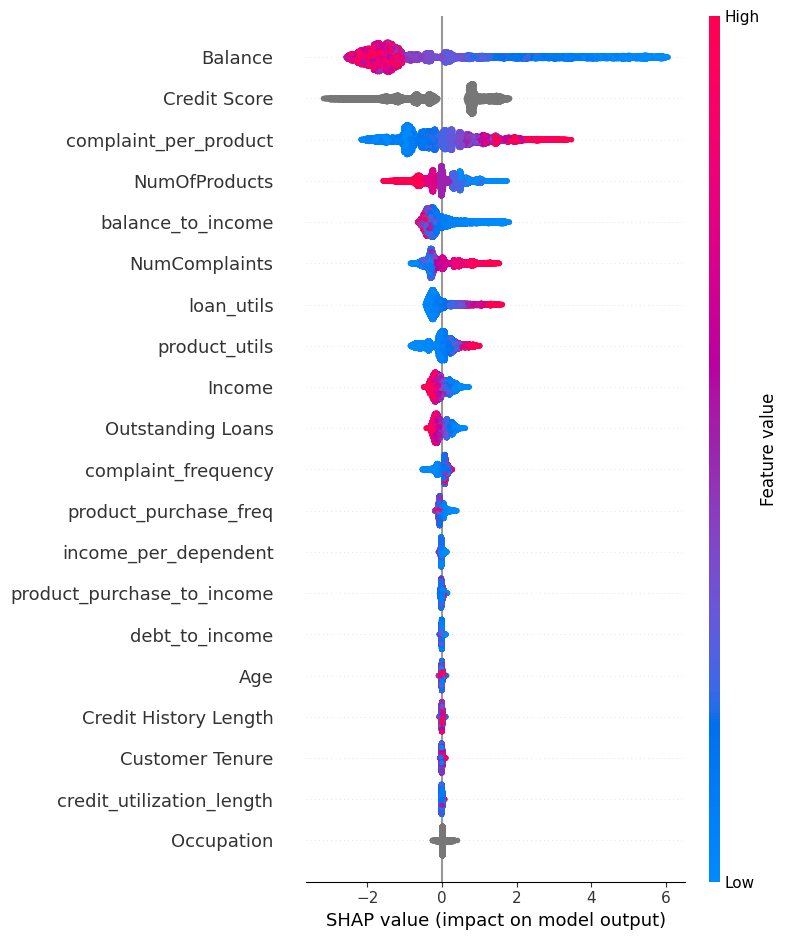

In [53]:
shap.summary_plot(shap_values, X_test)

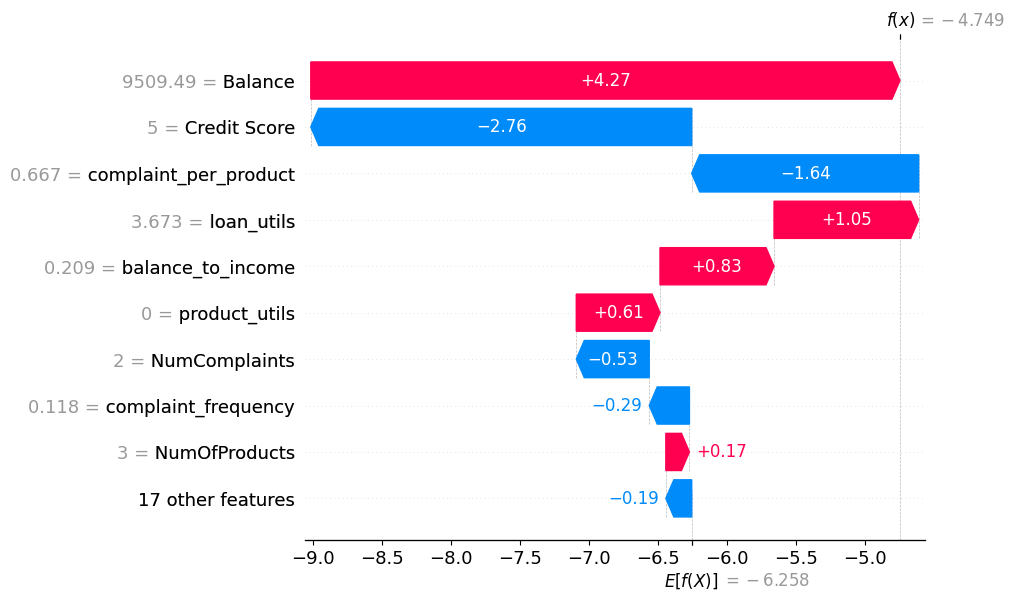

In [54]:
shap.waterfall_plot(shap_values[0])